# Statistical Learning 

## Class Competition: Netflix Data

## Predictions

 - Week 1: we had an error in script
 - Week 2: we used 2.5 for null values, prediction using Lasso + GBM
 - Week 3: $$user\_avg \cdot user\_prop + movie\_avg \cdot (1-user\_prop) - penalty$$ for nulls.
 - Week 4: Add some more features. 0.7 * lasso + 0.3 * gbm (+ bug fix from prior week)...
 - Week 5: Ensemble model.
 - Week 6: Added some new features and Truncated SVD
 - Week 7: New features: prop_i, xxx_is_rate. Predict using Lasso only.
 - Week 8: GBM + Lasso, with some new features, scaling outside lasso, and indicator for missing ratings.
 - Week 9: new features: min/max ratings. Fill nulls using Lasso. model - GBM + Lasso (mean)
 - Week 10: 

# Navigation

1. [Get Data](#Get-Data)
1. [New Features](#New-Features)
1. [Fix Nulls](#Fix-Nulls)
1. [Netflix Class](#Netflix-Class)
1. [Modeling & Tests](#Modeling-&-Tests)
    - [CV Results](#CV-Results)
1. [Prediction](#Prediction)
1. [Data Exploration & Visualisation](#Data-Exploration-&-Visualisation)

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.cluster import KMeans
 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cosine

# from sklearn.preprocessing import Imputer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import svd

# class imputation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Imputer
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y

# from surprise import evaluate, print_perf, Dataset
# from surprise import SVD, SVDpp

import time

from ggplot import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Get Data

[Top](#Navigation)

In [2]:
# read data
X_train = pd.read_csv("Data/X_train.csv")
X_train_dates = pd.read_csv("Data/X_train_dates.csv")
y_train_dates = pd.read_csv("Data/y_train_dates.csv")
y_train_full = pd.read_csv("Data/y_train.csv")

X_test = pd.read_csv("Data/X_test.csv")
X_test_dates = pd.read_csv("Data/X_test_dates.csv")
y_test_dates = pd.read_csv("Data/y_test_dates.csv")

titles = pd.read_csv("Data/titles.csv")

# col names
titles.columns = ['date', 'title']
X_train.columns = titles.title
X_train_dates.columns = titles.title
X_test.columns = titles.title
X_test_dates.columns = titles.title

X_train.head()

title,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,...,Somethings Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook
0,4,4,3,5,4,5,4,4,5,4,...,5,5,4,4,5,5,5,5,0,4
1,4,5,3,3,4,3,4,4,3,2,...,4,4,3,2,3,3,0,3,3,5
2,5,5,5,5,4,5,4,3,4,5,...,5,4,4,0,0,5,5,0,0,0
3,5,5,5,5,4,5,5,3,4,5,...,4,5,5,4,4,2,4,2,2,0
4,5,5,5,5,5,5,5,5,5,5,...,3,0,3,0,2,4,5,4,0,5


## New Features

[Top](#Navigatin)

In [3]:
# similar movies
corr_tmp = X_train.copy()
corr_tmp['response'] = y_train_full.V1
corr = corr_tmp.corr()
similar_movies = corr.response[(corr.response > .3) & (corr.response < 1)].index.tolist()
similar_movies

['Pretty Woman',
 'Twister',
 'Sweet Home Alabama',
 'What Women Want',
 'Sister Act',
 'Two Weeks Notice',
 'The Wedding Planner',
 'Maid in Manhattan']

In [4]:
# dissimilar movies
dissimilar_movies = corr.response[(corr.response < -.1)].index.tolist()
dissimilar_movies

['American Beauty',
 'Lost in Translation',
 'Pulp Fiction',
 'The Royal Tenenbaums',
 'Kill Bill: Vol. 1',
 'Memento',
 'Fight Club',
 'Sideways',
 'Kill Bill: Vol. 2',
 'Napoleon Dynamite']

In [165]:
def new_features(ratings_df, dates_df, y_dates, 
                 similar_movies = ['Pretty Woman', 'Twister', 'Sweet Home Alabama', 
                                   'What Women Want', 'Sister Act', 'Two Weeks Notice', 
                                   'The Wedding Planner', 'Maid in Manhattan'], 
                 dissimilar_movies = ['American Beauty', 'Lost in Translation', 'Pulp Fiction',
                                      'The Royal Tenenbaums', 'Kill Bill: Vol. 1', 'Memento', 'Fight Club',
                                       'Sideways', 'Kill Bill: Vol. 2', 'Napoleon Dynamite'],
                 na_val = 2.5):
    """
    """
    df = ratings_df.copy()
    number_of_ratings_per_user = ratings_df.apply(lambda x : sum(x != 0), axis = 1)
    avg_of_ratings_per_user = ratings_df.apply(lambda x : np.mean(x[x != 0]), axis = 1)
    median_of_ratings_per_user = ratings_df.apply(lambda x : np.median(x[x != 0]), axis = 1)
    sd_of_ratings_per_user = ratings_df.apply(lambda x : np.std(x[x != 0]), axis = 1)
    min_ratings_per_user = ratings_df.apply(lambda x : np.min(x[x != 0]), axis = 1)
    max_ratings_per_user = ratings_df.apply(lambda x : np.max(x[x != 0]), axis = 1)
    
    # proportion of i ratings per user
    prop_1 = ratings_df.apply(lambda x : np.mean(x == 1), axis = 1)
    prop_2 = ratings_df.apply(lambda x : np.mean(x == 2), axis = 1)
    prop_3 = ratings_df.apply(lambda x : np.mean(x == 3), axis = 1)
    prop_4 = ratings_df.apply(lambda x : np.mean(x == 4), axis = 1)
    prop_5 = ratings_df.apply(lambda x : np.mean(x == 5), axis = 1)
    
    days_since_first_rating = y_dates.V1 - dates_df.apply(lambda x : min(x[x != 0]), axis = 1)
    
    # similar movies
    sim_mean = ratings_df[similar_movies].apply(lambda x : np.mean(x[x != 0]) if len(x) > 0 else None, axis = 1)
    sim_sd = ratings_df[similar_movies].apply(lambda x : np.std(x[x != 0]) if len(x) > 0 else None, axis = 1)
    sim_num = ratings_df[similar_movies].apply(lambda x : len(x[x != 0]) if len(x) > 0 else None, axis = 1)
    # dissimilar movies
    dissim_mean = ratings_df[dissimilar_movies].apply(lambda x : np.mean(x[x != 0]) if len(x) > 0 else None, axis = 1)
    dissim_sd = ratings_df[dissimilar_movies].apply(lambda x : np.std(x[x != 0]) if len(x) > 0 else None, axis = 1)
    dissim_num = ratings_df[dissimilar_movies].apply(lambda x : len(x[x != 0]) if len(x) > 0 else None, axis = 1)
    # date
#     tmp_date = dates_df.copy()
#     tmp_date['y_dates'] = y_dates
#     num_same_date_ratings = tmp_date.apply(lambda x : sum(x == x.y_dates) - 1, axis = 1)
    same_date_df = ratings_df.where(dates_df.apply(lambda x : x == y_dates.V1))
    same_date_sim_df = ratings_df[similar_movies].where(dates_df[similar_movies].\
                                                     apply(lambda x : x == y_dates.V1))
    same_date_dissim_df = ratings_df[dissimilar_movies].where(dates_df[dissimilar_movies].\
                                                     apply(lambda x : x == y_dates.V1))

    avg_ratings_before = []
    num_ratings_before = []
    avg_ratings_after = []
    num_ratings_after = []

    for i in range(ratings_df.shape[0]):
        tmp_b = ratings_df.iloc[i][(dates_df.iloc[i] <= y_dates.iloc[i].V1)]
        tmp_a = ratings_df.iloc[i][(dates_df.iloc[i] > y_dates.iloc[i].V1)]
        avg_ratings_before.append(np.mean(tmp_b[tmp_b != 0]))
        avg_ratings_after.append(np.mean(tmp_a[tmp_a != 0]))
        num_ratings_before.append(sum(tmp_b != 0))
        num_ratings_after.append(sum(tmp_a != 0))
    
    tmp_ = dates_df.replace(0, np.nan).copy()
    for col in dates_df.columns:
        tmp_[col] = ((tmp_[col] // 365 + 1999) - titles.loc[titles.title == col, 'date'].values)
    
    corr_ = []
    for i in tmp_.index:
        t1 = tmp_.iloc[i]
        t2 = ratings_df.iloc[i]
        corr_.append(np.corrcoef(t1[t1.notnull()], t2[t2 != 0])[1,0])
    
    # factors for ratings yes/no
    non_full_cols = ratings_df.columns[14:]
    factors_df = (ratings_df[non_full_cols] != 0) * 1
    factors_df.columns = [x + '_is_rate' for x in non_full_cols]
    df = pd.concat([df.reset_index(drop = True), 
                    factors_df.reset_index(drop = True)], axis = 1)
    
    # new features
    df['y_dates'] = y_dates.V1
    
    df['number_of_ratings_per_user'] = number_of_ratings_per_user
    df['avg_of_ratings_per_user'] = avg_of_ratings_per_user
    df['median_of_ratings_per_user'] = median_of_ratings_per_user
    df['sd_of_ratings_per_user'] = sd_of_ratings_per_user
    df['min_ratings_per_user'] = min_ratings_per_user
    df['max_ratings_per_user'] = max_ratings_per_user
    df['days_since_first_rating'] = days_since_first_rating
    
    df['prop_1'] = prop_1
    df['prop_2'] = prop_2
    df['prop_3'] = prop_3
    df['prop_4'] = prop_4
    df['prop_5'] = prop_5
    
    df['num_same_date_ratings'] = same_date_df.count(axis = 1)
    df['mean_same_date_ratings'] = same_date_df.mean(axis = 1)
    df['sd_same_date_ratings'] = same_date_df.std(axis = 1)
    
    df['num_same_date_ratings_sim'] = same_date_sim_df.count(axis = 1)
    df['mean_same_date_ratings_sim'] = same_date_sim_df.mean(axis = 1)
    df['sd_same_date_ratings_sim'] = same_date_sim_df.std(axis = 1)
    
    df['num_same_date_ratings_dissim'] = same_date_dissim_df.count(axis = 1)
    df['mean_same_date_ratings_dissim'] = same_date_dissim_df.mean(axis = 1)
    df['sd_same_date_ratings_dissim'] = same_date_dissim_df.std(axis = 1)
    
    df['similar_mean'] = sim_mean
    df['similar_sd'] = sim_sd
    df['similar_number'] = sim_num
    df['dissimilar_mean'] = dissim_mean
    df['dissimilar_sd'] = dissim_sd
    df['dissimilar_number'] = dissim_num

    df['avg_ratings_before'] = avg_ratings_before
    df['num_ratings_before'] = num_ratings_before
    df['avg_ratings_after'] = avg_ratings_after
    df['num_ratings_after'] = num_ratings_after
    df['avg_num_before'] = df.num_ratings_before / (df.num_ratings_before + df.num_ratings_after)
    
    df['date_year_corr'] = corr_

    # na to mean
    df.fillna(df.mean(), inplace = True) # change na_val?
    
    return df

## Fix Nulls

[Top](#Navigation)

In [6]:
def na_fix(df, prop_user, penalty, cols):
    """
    Fill null values with avg_rating_user * prop_user + avg_rating_movie * (1 - prop_user) - penalty
    """
    avg_rating_per_movie = df[cols].replace(0, np.nan).mean(skipna = True)
    avg_rating_per_user = df[cols].apply(lambda x : np.mean(x[x != 0]), axis = 1)
    
    na_fix = df.copy()
    for column in cols:
        na_fix[column] = avg_rating_per_user * prop_user + avg_rating_per_movie[column] * (1 - prop_user) - penalty
        
    df_imp = df.copy()
    df_imp = df_imp.where(df_imp[cols] != 0, na_fix[cols]) # fill zeros with new values...
    
    return df_imp

In [167]:
## Inputing missing values
class PredictiveImputerAltered(BaseEstimator, TransformerMixin):
    def __init__(self, max_iter=10, initial_strategy='mean', tol=1e-3, f_model="RandomForest"):
        self.max_iter = max_iter
        self.initial_strategy = initial_strategy
        self.initial_imputer = Imputer(strategy=initial_strategy)
        self.tol = tol
        self.f_model = f_model

    def fit(self, X, y=None, **kwargs):
        X = check_array(X, dtype=np.float64, force_all_finite=False)

        X_nan = np.isnan(X)
        most_by_nan = X_nan.sum(axis=0).argsort()[::-1]

        imputed = self.initial_imputer.fit_transform(X)
        new_imputed = imputed.copy()

        self.statistics_ = np.ma.getdata(X)
        self.gamma_ = []

        if self.f_model == "RandomForest":
            self.estimators_ = [RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=i, **kwargs) \
                                for i in range(X.shape[1])]
        elif self.f_model == "Lasso":
            print ("Imputing using Lasso...")
            self.estimators_ = [LassoCV(n_alphas=400, max_iter=5000, random_state=i, **kwargs) \
                                for i in range(X.shape[1])]
        elif self.f_model == "KNN":
            self.estimators_ = [KNeighborsRegressor(n_neighbors=min(5, sum(~X_nan[:, i])), **kwargs) \
                                for i in range(X.shape[1])]
        elif self.f_model == "PCA":
            self.estimators_ = [PCA(n_components=int(np.sqrt(min(X.shape))), whiten=True, **kwargs)]

        for iter in range(self.max_iter):
            if len(self.estimators_) > 1:
                for i in most_by_nan:

                    X_s = np.delete(new_imputed, i, 1)
                    y_nan = X_nan[:, i]

                    X_train = X_s[~y_nan]
                    y_train = new_imputed[~y_nan, i]
                    X_unk = X_s[y_nan]

                    estimator_ = self.estimators_[i]
                    estimator_.fit(X_train, y_train)
                    if len(X_unk) > 0:
                        new_imputed[y_nan, i] = estimator_.predict(X_unk)

            else:
                estimator_ = self.estimators_[0]
                estimator_.fit(new_imputed)
                new_imputed[X_nan] = estimator_.inverse_transform(estimator_.transform(new_imputed))[X_nan]

            gamma = ((new_imputed-imputed)**2/(1e-6+new_imputed.var(axis=0))).sum()/(1e-6+X_nan.sum())
            self.gamma_.append(gamma)
            if np.abs(np.diff(self.gamma_[-2:])) < self.tol:
                break

        return self

    def transform(self, X):
        check_is_fitted(self, ['statistics_', 'estimators_', 'gamma_'])
        X = check_array(X, copy=True, dtype=np.float64, force_all_finite=False)
        if X.shape[1] != self.statistics_.shape[1]:
            raise ValueError("X has %d features per sample, expected %d"
                             % (X.shape[1], self.statistics_.shape[1]))

        X_nan = np.isnan(X)
        imputed = self.initial_imputer.fit_transform(X)

        if len(self.estimators_) > 1:
            for i, estimator_ in enumerate(self.estimators_):
                X_s = np.delete(imputed, i, 1)
                y_nan = X_nan[:, i]

                X_unk = X_s[y_nan]
                if len(X_unk) > 0:
                    X[y_nan, i] = estimator_.predict(X_unk)

        else:
            estimator_ = self.estimators_[0]
            X[X_nan] = estimator_.inverse_transform(estimator_.transform(imputed))[X_nan]

        return X

In [152]:
def test_predictive_imputer(df, f_model = 'Lasso'):
    imputer = PredictiveImputerAltered(max_iter = 20, f_model = f_model)
    df_imp = imputer.fit(df).transform(df.copy())
    return pd.DataFrame(df_imp, columns = df.columns)

In [142]:
start = time.time()
X_train_lasso_imputer = test_predictive_imputer(X_train.replace(0, np.nan))
end = time.time()
print ((end - start) / 60)

Imputing using Lasso...
11.008291081587474


In [143]:
pd.set_option("display.max_columns", 200)
X_train_lasso_imputer.head()

title,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,Pearl Harbor,Armageddon,The Rock,What Women Want,Bruce Almighty,Oceans Eleven,The Bourne Identity,The Italian Job,I Robot,American Beauty,How to Lose a Guy in 10 Days,Lethal Weapon 4,Shrek 2,Lost in Translation,Top Gun,Pulp Fiction,Gone in 60 Seconds,The Sixth Sense,Lord of the Rings: The Two Towers,Men of Honor,Gladiator,Lord of the Rings: The Fellowship of the Ring,Sister Act,Double Jeopardy,Two Weeks Notice,Troy,The Royal Tenenbaums,National Treasure,50 First Dates,Indiana Jones and the Last Crusade,My Big Fat Greek Wedding,Mystic River,Titanic,Dirty Dancing,Catch Me If You Can,Finding Nemo (Widescreen),The Matrix,Kill Bill: Vol. 1,The Wedding Planner,The Shawshank Redemption Special Edition,The Last Samurai,John Q,Swordfish,The Bourne Supremacy,The Terminal,Men in Black II,Spider-Man 2,Braveheart,Men in Black,Ghost,Air Force One,Lord of the Rings: The Return of the King,Man on Fire,The Incredibles,Mr Deeds,Collateral,Spider-Man,Saving Private Ryan,Erin Brockovich,Monsters Inc.,Shrek (Full-screen),The Silence of the Lambs,Memento,Tomb Raider,Ferris Buellers Day Off,Maid in Manhattan,Entrapment,Meet the Parents,Dodgeball A True Underdog Story,Rain Man,Patch Adams,Big Fish,Fight Club,S.W.A.T.,Good Will Hunting,A Few Good Men,Enemy of the State,The Generals Daughter,Minority Report,Somethings Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook
0,4.0,4.0,3.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,4.221371,5.000000,4.000000,5.0,5.000000,5.000000,4.0,5.00000,4.0,4.00000,5.0,5.000000,5.000000,5.0,3.000000,4.190221,4.000000,4.000000,4.000000,4.255784,4.0,5.000000,4.108817,5.000000,4.0,3.609249,4.0,5.0,5.000000,5.000000,2.00000,5.000000,4.0,5.000000,3.0,5.000000,4.000,4.0,4.000000,5.000000,5.000000,3.886415,3.000000,4.0,5.000000,5.000000,5.000000,4.296860,4.296788,5.000000,4.000000,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,4.000000,5.000000,5.0,5.000000,5.000000,4.0,4.000000,5.000000,5.000000,4.000000,4.000000,5.0,5.000000,4.0,4.000000,5.00000,5.0,5.000000,5.000000,3.911211,4.000000
1,4.0,5.0,3.0,3.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,4.0,4.0,4.0,3.0,4.0,3.0,3.0,3.000000,3.000000,3.362457,5.0,3.000000,1.000000,3.0,4.00000,3.0,4.00000,5.0,3.000000,5.000000,5.0,3.183277,2.000000,3.116181,3.000000,2.000000,3.000000,3.0,4.000000,3.000000,4.000000,3.0,3.269389,3.0,3.0,3.000000,3.000000,3.13344,5.000000,3.0,4.000000,3.0,3.000000,4.000,3.0,3.000000,5.000000,3.000000,3.000000,3.000000,5.0,4.000000,3.646412,3.067191,4.000000,3.302526,4.000000,3.000000,3.791752,3.669618,4.000000,2.540708,3.000000,3.000000,2.904027,3.000000,4.000000,3.000000,4.000000,5.0,3.293392,2.000000,3.0,5.000000,4.000000,3.487781,2.000000,3.000000,4.0,4.000000,3.0,2.000000,3.00000,3.0,2.757789,3.000000,3.000000,5.000000
2,5.0,5.0,5.0,5.0,4.0,5.0,4.0,3.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.000000,3.821172,5.000000,4.0,5.000000,2.815738,5.0,3.90982,4.0,5.00000,5.0,5.000000,5.000000,5.0,3.000000,4.000000,5.000000,4.910723,2.470681,5.000000,5.0,4.000000,3.000000,4.158758,5.0,4.000000,5.0,5.0,5.000000,3.728524,4.00000,5.000000,5.0,4.419252,5.0,5.000000,4.000,4.0,5.000000,5.000000,5.000000,4.000000,4.182142,5.0,5.000000,5.000000,4.000000,4.240423,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.566017,4.000000,4.423334,4.000000,4.186959,4.536651,3.944847,4.511523,5.0,3.983354,4.076263,5.0,5.000000,5.000000,5.000000,4.000000,4.259084,5.0,4.000000,4.0,3.048712,3.69383,5.0,5.000000,4.024621,2.874313,4.854731
3,5.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.000000,5.000000,5.000000,2.0,4.792714,3.393779,5.0,4.00000,4.0,5.00000,5.0,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,3.0

In [153]:
start = time.time()
X_train_rf_imputer = test_predictive_imputer(X_train.replace(0, np.nan), f_model = 'RandomForest')
end = time.time()
print ((end - start) / 60)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
53.34881321589152


In [154]:
# pd.set_option("display.max_columns", 200)
X_train_rf_imputer.head()

title,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,Pearl Harbor,Armageddon,The Rock,What Women Want,Bruce Almighty,Oceans Eleven,The Bourne Identity,The Italian Job,I Robot,American Beauty,How to Lose a Guy in 10 Days,Lethal Weapon 4,Shrek 2,Lost in Translation,Top Gun,Pulp Fiction,Gone in 60 Seconds,The Sixth Sense,Lord of the Rings: The Two Towers,Men of Honor,Gladiator,Lord of the Rings: The Fellowship of the Ring,Sister Act,Double Jeopardy,Two Weeks Notice,Troy,The Royal Tenenbaums,National Treasure,50 First Dates,Indiana Jones and the Last Crusade,My Big Fat Greek Wedding,Mystic River,Titanic,Dirty Dancing,Catch Me If You Can,Finding Nemo (Widescreen),The Matrix,Kill Bill: Vol. 1,The Wedding Planner,The Shawshank Redemption Special Edition,The Last Samurai,John Q,Swordfish,The Bourne Supremacy,The Terminal,Men in Black II,Spider-Man 2,Braveheart,Men in Black,Ghost,Air Force One,Lord of the Rings: The Return of the King,Man on Fire,The Incredibles,Mr Deeds,Collateral,Spider-Man,Saving Private Ryan,Erin Brockovich,Monsters Inc.,Shrek (Full-screen),The Silence of the Lambs,Memento,Tomb Raider,Ferris Buellers Day Off,Maid in Manhattan,Entrapment,Meet the Parents,Dodgeball A True Underdog Story,Rain Man,Patch Adams,Big Fish,Fight Club,S.W.A.T.,Good Will Hunting,A Few Good Men,Enemy of the State,The Generals Daughter,Minority Report,Somethings Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook
0,4.0,4.0,3.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,4.22,5.00,4.00,5.0,5.00,5.00,4.0,5.00,4.0,4.00,5.0,5.0,5.00,5.0,3.00,4.02,4.00,4.0,4.00,4.40,4.0,5.00,4.19,5.00,4.0,3.85,4.0,5.0,5.00,5.00,2.00,5.0,4.0,5.00,3.0,5.00,4.00,4.0,4.00,5.00,5.00,3.93,3.00,4.0,5.00,5.00,5.00,4.29,4.15,5.00,4.00,5.00,5.00,5.00,4.00,4.00,4.00,3.00,5.00,5.00,4.00,5.00,5.0,5.00,5.00,4.0,4.0,5.00,5.00,4.00,4.0,5.0,5.00,4.0,4.00,5.0,5.0,5.00,5.00,4.09,4.00
1,4.0,5.0,3.0,3.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,4.0,4.0,4.0,3.0,4.0,3.0,3.0,3.00,3.00,3.72,5.0,3.00,1.00,3.0,4.00,3.0,4.00,5.0,3.0,5.00,5.0,3.18,2.00,3.21,3.0,2.00,3.00,3.0,4.00,3.00,4.00,3.0,3.64,3.0,3.0,3.00,3.00,3.21,5.0,3.0,4.00,3.0,3.00,4.00,3.0,3.00,5.00,3.00,3.00,3.00,5.0,4.00,4.09,2.85,4.00,3.40,4.00,3.00,4.13,3.73,4.00,2.91,3.00,3.00,2.95,3.00,4.00,3.00,4.00,5.0,3.50,2.00,3.0,5.0,4.00,3.24,2.00,3.0,4.0,4.00,3.0,2.00,3.0,3.0,2.89,3.00,3.00,5.00
2,5.0,5.0,5.0,5.0,4.0,5.0,4.0,3.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.00,3.91,5.00,4.0,5.00,2.63,5.0,3.63,4.0,5.00,5.0,5.0,5.00,5.0,3.00,4.00,5.00,4.8,2.60,5.00,5.0,4.00,3.00,3.91,5.0,4.00,5.0,5.0,5.00,3.79,4.00,5.0,5.0,4.61,5.0,5.00,4.00,4.0,5.00,5.00,5.00,4.00,4.35,5.0,5.00,5.00,4.00,3.92,5.00,5.00,5.00,5.00,5.00,5.00,3.69,4.00,4.21,4.00,4.25,4.66,3.92,4.65,5.0,4.04,3.97,5.0,5.0,5.00,5.00,4.00,4.1,5.0,4.00,4.0,3.35,3.5,5.0,5.00,3.89,3.06,4.81
3,5.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.00,5.00,5.00,2.0,4.54,3.15,5.0,4.00,4.0,5.00,5.0,5.0,5.00,5.0,5.00,5.00,5.00,5.0,3.00,5.00,4.0,4.63,4.00,5.00,5.0,5.00,3.0,5.0,5.00,3.00,5.00,5.0,5.0,5.00,3.0,4.27,4.14,5.0,4.44,5.00,3.00,4.00,3.00,5.0,4.58,4.00,5.00,4.00,5.00,5.00,3.00,3.00,5.00,4.00,5.00,5.00,5.00,3.00,4.00,5.00,3.00,4.00,5.0,3.91,2.00,3.0,5.0,5.00,4.00,5.00,3.0,4.0,5.00,5.0,4.00,4.0,2.0,4.00,2.00,2.00,4.70
4,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,3.0,4.0,5.0,5.0,5.0,3.00,5.00,3.00,1.0,5.00,1.00,5.0,5.00,5.0,4.68,5.0,4.2,4.22,5.0,2.00,3.00,3.00,5.0,1.98,4.21,3.0,4.46,5.00,4.00,5.0,5.00,4.0,5.0,4.35,1.00,3.00,4.5,5.0,5.00,1.0,5.00,1.00,2.0,5.00,4.31,3.63,5.00,3.00,5.0,5.00,4.59,5.00,5.00,5.00,4.35,3.91,5.00,4.76,4.36,1.00,3.33,4.17,1.00,3.32,4.04,2.00,4.23,3.0,3.59,3.53,5.0,4.1,4.43,3.47,3.21,3.0,3.0,4.64,3.0,3.22,2.0,4.0,5.00,4.00,3.45,5.00


## Netflix Class

All model's and methods...

[Top](#Navigation)

In [17]:
class NetflixPrize:
    """
    Main class for modeling and prediction 
    """
    
    def __init__(self, X_train, y_train, X_test, y_test = None, use_residuals = False, cv = 5):
        """
        Initialize ensemble model
        """
        self.X_train = X_train
        self.y_train = y_train.values.ravel()
        self.X_test = X_test
        if y_test is not None:
            self.y_test = y_test.values.ravel()
        else:
            self.y_test = None
        self.use_residuals = use_residuals
        self.cv = cv
        
    #####################
    # General Functions #
    #####################
    
    def rmse_calc(self, true, pred):
        """
        Calculate RMSE
        """
        return np.sqrt(mean_squared_error(true, pred))
    
    def get_residuals(self, true, pred):
        """
        Get residuals
        """
        return true - pred
        
   
    #########
    # Lasso #
    #########
    
    def lasso_cv_model(self, n_alphas = 200, max_iter = 5000, normalize = True):
        """
        Initialize Lasso model
        """
        self.lasso_cv_model_ = LassoCV(n_alphas = n_alphas, max_iter = max_iter, normalize = normalize)
        return self.lasso_cv_model_
    
    def lasso_cv_fit(self, X_train, y_train, 
                     n_alphas = 200, max_iter = 5000, normalize = True):
        """
        Fit Lasso model
        """
        lasso_mod = self.lasso_cv_model(n_alphas = n_alphas, max_iter = max_iter, normalize = normalize)
        self.lasso_cv_fit_ = lasso_mod.fit(X_train, y_train)
        return self.lasso_cv_fit_
    
    def lasso_cv_predict(self, X_train, y_train, X_test, 
                         n_alphas = 200, max_iter = 5000, normalize = True):
        """
        Predict using Lasso
        """
        lasso_fit = self.lasso_cv_fit(X_train, y_train, n_alphas = n_alphas, 
                                      max_iter = max_iter, normalize = normalize)
        self.lasso_pred_ = lasso_fit.predict(X_test)
        
        # fix
        self.lasso_pred_[self.lasso_pred_ < 1] = 1
        self.lasso_pred_[self.lasso_pred_ > 5] = 5
        
        return self.lasso_pred_
    
    #######
    # GBM #
    #######
    
    def gbm_model(self, learning_rate = .025, n_estimators = 400):
        """
        Initialize GBM model
        """
        self.gbm_model_ = GradientBoostingRegressor(learning_rate = learning_rate, n_estimators = n_estimators)
        return self.gbm_model_
    
    def gbm_fit(self, X_train, y_train, learning_rate = .025, n_estimators = 400):
        """
        Fit GBM model
        """
        gbm_mod = self.gbm_model(learning_rate = learning_rate, n_estimators = n_estimators)
        self.gbm_fit_ = gbm_mod.fit(X_train, y_train)
        return self.gbm_fit_
    
    def gbm_predict(self, X_train, y_train, X_test, 
                    learning_rate = .025, n_estimators = 400):
        """
        Predict using GBM
        """
        gbm_fit = self.gbm_fit(X_train, y_train, learning_rate = learning_rate, n_estimators = n_estimators)
        self.gbm_pred_ = gbm_fit.predict(X_test)
        
        # fix
        self.gbm_pred_[self.gbm_pred_ < 1] = 1
        self.gbm_pred_[self.gbm_pred_ > 5] = 5
        
        return self.gbm_pred_
    
    ######
    # RF #
    ######
    
    def rf_model(self, n_estimators = 100):
        """
        Initialize RF model
        """
        self.rf_model_ = RandomForestRegressor(n_estimators = n_estimators)
        return self.rf_model_
    
    def rf_fit(self, X_train, y_train, n_estimators = 100):
        """
        Fit RF model
        """
        rf_mod = self.rf_model(n_estimators = n_estimators)
        self.rf_fit_ = rf_mod.fit(X_train, y_train)
        return self.rf_fit_
    
    def rf_predict(self, X_train, y_train, X_test, n_estimators = 100):
        """
        Predict using RF
        """
        rf_fit = self.rf_fit(X_train, y_train, n_estimators = n_estimators)
        self.rf_pred_ = rf_fit.predict(X_test)
        
        # fix
        self.rf_pred_[self.rf_pred_ < 1] = 1
        self.rf_pred_[self.rf_pred_ > 5] = 5
        
        return self.rf_pred_
    
    #######
    # PCA #
    #######
    
    def pca_model(self, n_components = 10):
        """
        Fit PCA
        """
        self.pca_model_ = PCA(n_components = n_components)
        
        return self.pca_model_
    
    def pca_fit(self, df_fit, n_components = 10):
        """
        Fit PCA
        """
        pca_model = PCA(n_components = n_components)
        self.pca_fit_ = pca_model.fit(df_fit)
        
        return self.pca_fit_
            
    
    def pca_transform(self, df_transform, df_fit = None, n_components = 10, scale = True):
        """
        PCA transform
        """
        if df_fit is None:
            df_fit = df_transform.copy()
            
        if scale:
            scale = StandardScaler()
            scale_fit = scale.fit(df_fit)
            df_fit = scale_fit.transform(df_fit)
            df_transform = scale_fit.transform(df_transform)
            
        pca_fit = self.pca_fit(df_fit, n_components = n_components)
        pca_df = pca_fit.transform(df_transform)
        
        return pca_df
    
    ########
    # k-NN #
    ########
    
    def knn_model(self, n_neighbors = 100, weights = 'distance', p = 1):
        """
        Initialize k-NN model
        """
        self.knn_model_ = KNeighborsRegressor(n_neighbors = n_neighbors, weights = weights, p = p)
        
        return self.knn_model_
    
    def knn_fit(self, X_train, y_train, n_neighbors = 100, weights = 'distance', p = 1):
        """
        Fit k-NN model
        """
        knn_model = self.knn_model(n_neighbors = n_neighbors, weights = weights, p = p)
        self.knn_fit_ = knn_model.fit(X_train, y_train)
        
        return self.knn_fit_
    
    def knn_predict(self, X_train, y_train, X_test, n_neighbors = 100, weights = 'distance', p = 1):
        """
        Predict using k-NN
        """
        knn_fit = self.knn_fit(X_train, y_train, n_neighbors = n_neighbors, weights = weights, p = p)
        self.knn_pred_ = knn_fit.predict(X_test)
        
        # fix
        self.knn_pred_[self.knn_pred_ < 1] = 1
        self.knn_pred_[self.knn_pred_ > 5] = 5
        
        return self.knn_pred_
    
    
    ##################
    # ensemble model #
    ##################
    
    def ensemble_model_fit_predict(self, X_train, y_train, X_val, y_val, X_test):
        """
        Fit an ensemble model
        """
        # PCA
        # 10 components
#         pca_X_train_10 = self.pca_transform(X_train)
#         pca_X_val_10 = self.pca_transform(X_val, X_train)
#         pca_X_test_10 = self.pca_transform(X_test, X_train)
        # 40 components
        pca_X_train_40 = self.pca_transform(X_train, n_components = 40)
        pca_X_val_40 = self.pca_transform(X_val, X_train, n_components = 40)
        pca_X_test_40 = self.pca_transform(X_test, X_train, n_components = 40)
        # Truncated SVD
        tsvd = TruncatedSVD(n_components = 99)
        X_train_tsvd = tsvd.fit_transform(X_train)
        X_test_tsvd = tsvd.transform(X_test)
        X_val_tsvd = tsvd.transform(X_val)
        # k-NN
#         knn_val_pred = self.knn_predict(pca_X_train_10, y_train, pca_X_val_10)
#         knn_test_pred = self.knn_predict(pca_X_train_10, y_train, pca_X_test_10)
        # lasso
        lassso_fit = LassoCV(n_alphas=400, max_iter=5000, normalize=True).fit(X_train, y_train)
        lasso_val_pred = lassso_fit.predict(X_val)
        lasso_test_pred = lassso_fit.predict(X_test)
        # lasso PCA
        lassso_fit_pca = LassoCV(n_alphas=400, max_iter=5000, normalize=True).fit(pca_X_train_40, y_train)
        lasso_val_pca_pred = lassso_fit_pca.predict(pca_X_val_40)
        lasso_test_pca_pred = lassso_fit_pca.predict(pca_X_test_40)
        # lasso tsvd
        lassso_fit_tsvd = LassoCV(n_alphas=400, max_iter=5000, normalize=True).fit(X_train_tsvd, y_train)
        lasso_val_tsvd_pred = lassso_fit_tsvd.predict(X_val_tsvd)
        lasso_test_tsvd_pred = lassso_fit_tsvd.predict(X_test_tsvd)
        # rf pred
        rf_fit = RandomForestRegressor(n_estimators = 400).fit(X_train, y_train)
        rf_val_pred = rf_fit.predict(X_val)
        rf_test_pred = rf_fit.predict(X_test)
        # rf pred PCA
        rf_fit_pca = RandomForestRegressor(n_estimators = 400).fit(pca_X_train_40, y_train)
        rf_val_pca_pred = rf_fit_pca.predict(pca_X_val_40)
        rf_test_pca_pred = rf_fit_pca.predict(pca_X_test_40)
        # rf pred TSVD
        rf_fit_tsvd = RandomForestRegressor(n_estimators = 400).fit(X_train_tsvd, y_train)
        rf_val_tsvd_pred = rf_fit_tsvd.predict(X_val_tsvd)
        rf_test_tsvd_pred = rf_fit_tsvd.predict(X_test_tsvd)
        # gbm pred
        gbm_fit = GradientBoostingRegressor(n_estimators=400, learning_rate=0.025).fit(X_train, y_train)
        gbm_val_pred = gbm_fit.predict(X_val)
        gbm_test_pred = gbm_fit.predict(X_test)
        # gbm pred PCA
        gbm_fit_pca = GradientBoostingRegressor(n_estimators=400, learning_rate=0.025).fit(pca_X_train_40, y_train)
        gbm_val_pca_pred = gbm_fit_pca.predict(pca_X_val_40)
        gbm_test_pca_pred = gbm_fit_pca.predict(pca_X_test_40)
        # GBM TSVD
        gbm_fit_tsvd = GradientBoostingRegressor(n_estimators=400, learning_rate=0.025).fit(X_train_tsvd, y_train)
        gbm_val_tsvd_pred = gbm_fit_tsvd.predict(X_val_tsvd)
        gbm_test_tsvd_pred = gbm_fit_tsvd.predict(X_test_tsvd)
        # all
        all_val_pred = pd.DataFrame({#'knn':knn_val_pred, 
                                     'lasso':lasso_val_pred, 
                                     'rf':rf_val_pred, 
                                     'gbm':gbm_val_pred, 
                                     'lasso_pca':lasso_val_pca_pred, 
                                     'rf_pca':rf_val_pca_pred,
                                     'gbm_pca':gbm_val_pca_pred,
                                     'lasso_tsvd':lasso_val_tsvd_pred,
                                     'rf_tsvd':rf_val_tsvd_pred,
                                     'gbm_tsvd':gbm_val_tsvd_pred})

        all_test_pred = pd.DataFrame({#'knn':knn_test_pred, 
                                      'lasso':lasso_test_pred, 
                                      'rf':rf_test_pred, 
                                      'gbm':gbm_test_pred, 
                                      'lasso_pca':lasso_test_pca_pred, 
                                      'rf_pca':rf_test_pca_pred,
                                      'gbm_pca':gbm_test_pca_pred,
                                      'lasso_tsvd':lasso_test_tsvd_pred,
                                      'rf_tsvd':rf_test_tsvd_pred,
                                      'gbm_tsvd':gbm_test_tsvd_pred})
        # final model
        
        # Remove intercept???
        final_lasso_pred = self.lasso_cv_predict(all_val_pred, y_val, all_test_pred) 
#         final_elastic_pred = ElasticNetCV(normalize = True).fit(all_val_pred, y_val).predict(all_test_pred) # tmp
        return final_lasso_pred

 
    def ensemble_rmse_cv(self, X_train, y_train, cv = 10, seed = 123):
        """
        Estimate ensemble's model RMSE using CV
        """
        data = X_train.copy()
        data['response'] = y_train

        random_ind = data.index.tolist()
        np.random.seed(seed)
        np.random.shuffle(random_ind) # random row index

        rmse_ = []
#         rmse_elastic = []
        split_ = np.array_split(random_ind, cv)
        for i, inds in enumerate(split_):
            print("%d out of %d" % (i+1, cv))
            # split test-train
            X_test = data.loc[data.index.isin(inds), data.columns[:X_train.shape[1]]]
            X_train = data.loc[~data.index.isin(inds), data.columns[:X_train.shape[1]]]
            y_test = data.loc[data.index.isin(inds)].response
            y_train = data.loc[~data.index.isin(inds)].response
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .5)
            # predict
            pred = self.ensemble_model_fit_predict(X_train, y_train, X_val, y_val, X_test)
            
            rmse_.append(self.rmse_calc(y_test, pred))
#             rmse_elastic.append(self.rmse_calc(y_test, pred_elastic))
            
            #, np.mean(rmse_elastic)
        return np.mean(rmse_)
    
    def ensemble_predict(self, X_train, y_train, X_test, val_frac = .1, seed = 0):
        """
        Predict using ensemble model
        """
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_frac, 
                                                          random_state = seed)
        
        pred = self.ensemble_model_fit_predict(X_train, y_train.values.ravel(), X_val, y_val.values.ravel(), X_test)
        
        pred[pred > 5] = 5
        pred[pred < 1] = 1
        
        return pred
    
    def back_to_basics_rmse_cv(self, X_train, y_train, cv = 10, seed = 123, normalize = True, fit_intercept = True):
        """
        
        """
        data = X_train.copy()
        data['response'] = y_train

        random_ind = data.index.tolist()
        np.random.seed(seed)
        np.random.shuffle(random_ind) # random row index

        rmse_ = []
        split_ = np.array_split(random_ind, cv)
        for i, inds in enumerate(split_):
            print("%d out of %d" % (i+1, cv))
            # split test-train
            X_test = data.loc[data.index.isin(inds), data.columns[:X_train.shape[1]]]
            X_train = data.loc[~data.index.isin(inds), data.columns[:X_train.shape[1]]]
            y_test = data.loc[data.index.isin(inds)].response
            y_train = data.loc[~data.index.isin(inds)].response
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .5)
            # predict
            # 40 components
            pca_X_train_40 = self.pca_transform(X_train, n_components = 40)
            pca_X_val_40 = self.pca_transform(X_val, X_train, n_components = 40)
            pca_X_test_40 = self.pca_transform(X_test, X_train, n_components = 40)
            # Truncated SVD
            tsvd = TruncatedSVD(n_components = 99)
            X_train_tsvd = tsvd.fit_transform(X_train)
            X_test_tsvd = tsvd.transform(X_test)
            X_val_tsvd = tsvd.transform(X_val)
            #####
            lassso_fit = LassoCV(n_alphas = 400, max_iter = 5000, normalize = normalize).fit(X_train, y_train)
            lasso_val_pred = lassso_fit.predict(X_val)
            lasso_test_pred = lassso_fit.predict(X_test)
            # lasso PCA
            lassso_fit_pca = LassoCV(n_alphas = 400, max_iter = 5000, normalize = normalize).\
                fit(pca_X_train_40, y_train)
            lasso_val_pca_pred = lassso_fit_pca.predict(pca_X_val_40)
            lasso_test_pca_pred = lassso_fit_pca.predict(pca_X_test_40)
            # lasso tsvd
            lassso_fit_tsvd = LassoCV(n_alphas = 400, max_iter = 5000, normalize = normalize).\
                fit(X_train_tsvd, y_train)
            lasso_val_tsvd_pred = lassso_fit_tsvd.predict(X_val_tsvd)
            lasso_test_tsvd_pred = lassso_fit_tsvd.predict(X_test_tsvd)
            
            all_val_pred = pd.DataFrame({'lasso':lasso_val_pred, 
                                          'lasso_pca':lasso_val_pca_pred, 
                                          'lasso_tsvd':lasso_val_tsvd_pred})

            all_test_pred = pd.DataFrame({'lasso':lasso_test_pred, 
                                          'lasso_pca':lasso_test_pca_pred, 
                                          'lasso_tsvd':lasso_test_tsvd_pred})
            
            ridge_fit = RidgeCV(fit_intercept=fit_intercept).fit(all_val_pred, y_val)
            pred = ridge_fit.predict(all_test_pred)
            rmse_.append(self.rmse_calc(y_test, pred))
        return rmse_

## Modeling & Tests

[Top](#Navigation)

In [6]:
# X_train.drop(['set'], axis = 1, inplace = True)
# X_test.drop(['set'], axis = 1, inplace = True)

In [18]:
##################################
# Add new features and Fix nulls #
##################################

## New Features
X_train_full = new_features(X_train, X_train_dates, y_train_dates)
X_test_full = new_features(X_test, X_test_dates, y_test_dates)
## Fix Nulls in test and train
X_train['set'] = 'train'
X_test['set'] = 'test'
all_rankings_data = X_train.append(X_test, ignore_index = True)
# params - Note that prop_user = .9 and penalty = 1.5 got smallest RMSE using CV and Lasso for prediction...
prop_user = .7
penalty = 1.5
all_rankings_data_na_fix = na_fix(all_rankings_data, prop_user, penalty, titles.title)
X_train_na_fix = all_rankings_data_na_fix.loc[all_rankings_data.set == 'train']
X_test_na_fix = all_rankings_data_na_fix.loc[all_rankings_data.set == 'test']

X_train.drop(['set'], axis = 1, inplace = True)
X_test.drop(['set'], axis = 1, inplace = True)

X_train_full_na_fix = X_train_na_fix.drop(['set'], axis = 1).copy()
X_test_full_na_fix = X_test_na_fix.drop(['set'], axis = 1).copy()

new_features_ = [col for col in X_train_full.columns if col not in X_train_na_fix.columns]

X_train_full_na_fix = pd.concat([X_train_full_na_fix.reset_index(drop = True), 
                                 X_train_full[new_features_].reset_index(drop = True)], axis = 1)

X_test_full_na_fix = pd.concat([X_test_full_na_fix.reset_index(drop = True), 
                                 X_test_full[new_features_].reset_index(drop = True)], axis = 1)

/Users/avivnavon/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/avivnavon/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [19]:
netflix = NetflixPrize(X_train_full_na_fix, y_train_full, X_test_full_na_fix, cv = 10)

In [599]:
#### Test #####
rmse_ = netflix.back_to_basics_rmse_cv(netflix.X_train, netflix.y_train, normalize = True)

1 out of 10
2 out of 10
3 out of 10
4 out of 10
5 out of 10
6 out of 10
7 out of 10
8 out of 10
9 out of 10
10 out of 10


In [600]:
np.mean(rmse_)

0.75653534411553225

In [601]:
rmse_

[0.74220011758334103,
 0.74260138434042311,
 0.73401240303428383,
 0.78142246045178398,
 0.74778782628270879,
 0.75234323415859705,
 0.75240541605618161,
 0.76266312818409976,
 0.78134255249861162,
 0.76857491856529025]

In [20]:
f = LassoCV(normalize = True, max_iter = 5000).fit(X_train_full_na_fix, 
                                        y_train_full.values.ravel())
res = pd.DataFrame({'coef':f.coef_, 'abs_':abs(f.coef_), 'name':X_train_full_na_fix.columns})
res.sort_values('abs_', ascending = False).head(10)

,abs_,coef,name
190,0.587037,-0.587037,prop_1
204,0.354397,0.354397,similar_mean
193,0.176583,-0.176583,prop_4
34,0.113447,0.113447,Two Weeks Notice
215,0.098718,-0.098718,date_year_corr
205,0.089561,0.089561,similar_sd
32,0.081042,0.081042,Sister Act
114,0.074417,-0.074417,Men of Honor_is_rate
102,0.062147,-0.062147,The Italian Job_is_rate
48,0.060736,0.060736,The Wedding Planner


### CV Results

In [155]:
# Train after lasso imp
new_features_ = [col for col in X_train_full.columns if col not in X_train_na_fix.columns]

X_train_full_na_fix_imputer = pd.concat([X_train_lasso_imputer.reset_index(drop = True), 
                                 X_train_full[new_features_].reset_index(drop = True)], axis = 1)

In [156]:
# Train after rf imp
new_features_ = [col for col in X_train_full.columns if col not in X_train_na_fix.columns]

X_train_full_na_fix_imputer_rf = pd.concat([X_train_rf_imputer.reset_index(drop = True), 
                                 X_train_full[new_features_].reset_index(drop = True)], axis = 1)

In [392]:
lasso_mod = LassoCV(max_iter = 5000, alphas = np.arange(.001, 1, .001), cv = 10) # normalize = True, 
cv = 100
scaled_ = pd.DataFrame(StandardScaler().fit_transform(X_train_full_na_fix), columns = X_train_full_na_fix.columns)
print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(lasso_mod, 
                                        scaled_, 
                                        y_train_full.values.ravel(), 
                                        scoring = "neg_mean_squared_error", 
                                        cv = cv).mean() * -1), 7))

In [715]:
lasso_mod = LassoCV(normalize = True, max_iter = 5000) # normalize = True, 
cv = 100
print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(lasso_mod, 
                                        X_train_full_na_fix, 
                                        y_train_full.values.ravel(), 
                                        scoring = "neg_mean_squared_error", 
                                        cv = cv).mean() * -1), 7))

RMSE using 100-fold CV is 0.7529059


In [393]:
lasso_mod = LassoCV(max_iter = 5000, alphas = np.arange(.001, 1, .001), cv = 10)
cv = 20
scaled_lasso_imp = pd.DataFrame(StandardScaler().fit_transform(X_train_full_na_fix_imputer), 
                       columns = X_train_full_na_fix_imputer.columns)

cv_results = cross_val_score(lasso_mod, 
                             scaled_lasso_imp, # with imputed data
                             y_train_full.values.ravel(), 
                             scoring = "neg_mean_squared_error", 
                             cv = cv)

In [394]:
print (np.sqrt(cv_results * -1).std(), ",", np.sqrt(cv_results * -1).mean())

0.0192252153403 , 0.751145303613


In [396]:
np.sqrt(cv_results * -1).max()

0.78271697811085417

In [158]:
cv = 100
scaled_rf_imp = pd.DataFrame(StandardScaler().fit_transform(X_train_full_na_fix_imputer_rf), 
                       columns = X_train_full_na_fix_imputer_rf.columns)

print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(lasso_mod, 
                                        scaled_rf_imp, # with imputed data (RF)
                                        y_train_full.values.ravel(), 
                                        scoring = "neg_mean_squared_error", 
                                        cv = cv).mean() * -1), 7))

RMSE using 100-fold CV is 0.7516957


In [650]:
ridge_mod = RidgeCV(alphas = [0.01, 0.05, 0.1, 0.5, 1, 10, 15])
cv = 100
print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(ridge_mod, 
                                        scaled_, 
                                        y_train_full.values.ravel(), 
                                        scoring = "neg_mean_squared_error", 
                                        cv = cv).mean() * -1), 7))

RMSE using 100-fold CV is 0.7538076


In [376]:
r = RidgeCV(alphas = np.arange(2160, 2163, .1), cv = 10).fit(scaled_lasso_imp, y_train_full.values.ravel())
r.alpha_

In [379]:
coefss = pd.DataFrame({'c_abs':abs(r.coef_), 'c':r.coef_, 'name':scaled_lasso_imp.columns})
coefss.sort_values('c_abs', ascending = False).head(10)

,c,c_abs,name
34,0.099787,0.099787,Two Weeks Notice
32,0.080158,0.080158,Sister Act
204,0.076909,0.076909,similar_mean
48,0.073789,0.073789,The Wedding Planner
9,0.054683,0.054683,Sweet Home Alabama
119,0.049760,0.049760,Two Weeks Notice_is_rate
68,0.048338,0.048338,Erin Brockovich
33,0.041883,0.041883,Double Jeopardy
117,0.038653,0.038653,Sister Act_is_rate
73,0.038468,0.038468,Tomb Raider


In [390]:
rr = LassoCV(max_iter = 5000, alphas = np.arange(.001, 1, .001), cv = 10).\
    fit(scaled_lasso_imp, y_train_full.values.ravel())
rr.alpha_

0.0050000000000000001

In [368]:
# coefss = pd.DataFrame({'c_abs':abs(rr.coef_), 'c':rr.coef_, 'name':scaled_lasso_imp.columns})
# coefss.sort_values('c_abs', ascending = False).head(20)

In [387]:
ridge_mod = RidgeCV(alphas = np.arange(2160, 2163, .1))
cv = 20
cv_results = cross_val_score(ridge_mod, 
                scaled_lasso_imp, # with imputed data
                y_train_full.values.ravel(), 
                scoring = "neg_mean_squared_error", 
                cv = cv)

In [388]:
print (np.sqrt(cv_results * -1).std(), ",", np.sqrt(cv_results * -1).mean())

0.0188060015522 , 0.75231077268


In [389]:
np.sqrt(cv_results * -1).max()

0.78470405249888409

In [159]:
ridge_mod = RidgeCV(alphas = [0.01, 0.05, 0.1, 0.5, 1, 10, 15])
cv = 100
print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(ridge_mod, 
                                        scaled_rf_imp, # with imputed data (RF)
                                        y_train_full.values.ravel(), 
                                        scoring = "neg_mean_squared_error", 
                                        cv = cv).mean() * -1), 7))

RMSE using 100-fold CV is 0.7545948


In [32]:
cv = 10
# [[x for x in X_test_full_na_fix.columns if '_is_rate' not in x]]
print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(
                            GradientBoostingRegressor(learning_rate = .025, n_estimators = 500), 
                            X_train_full_na_fix, 
                            y_train_full.values.ravel(), 
                            scoring = "neg_mean_squared_error", 
                            cv = cv).mean() * -1), 7))

RMSE using 10-fold CV is 0.761803


In [244]:
cv = 10
# [[x for x in X_test_full_na_fix.columns if '_is_rate' not in x]]
cv_results = cross_val_score(
                            GradientBoostingRegressor(learning_rate = .025, n_estimators = 500), 
                            scaled_lasso_imp,  # with imputed data
                            y_train_full.values.ravel(), 
                            scoring = "neg_mean_squared_error", 
                            cv = cv)

In [254]:
print (np.sqrt(cv_results * -1).std(), ",", np.sqrt(cv_results * -1).mean())

0.0142028643669 , 0.760148393409


In [162]:
cv = 10
# [[x for x in X_test_full_na_fix.columns if '_is_rate' not in x]]
print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(
                            GradientBoostingRegressor(learning_rate = .025, n_estimators = 500), 
                            scaled_rf_imp,  # with imputed data (RF)
                            y_train_full.values.ravel(), 
                            scoring = "neg_mean_squared_error", 
                            cv = cv).mean() * -1), 7))

RMSE using 10-fold CV is 0.7605424


In [163]:
tmp = scaled_lasso_imp.copy()
tmp['response'] = y_train_full.copy()

random_ind = tmp.index.tolist()
np.random.shuffle(random_ind) # random row index

rmses_lasso = []
rmses_gbm = []
rmses_both = []
rmses_both_ = []
cv = 20
features_ = [name for name in tmp.columns if name != 'response']
for i, inds in enumerate(np.array_split(random_ind, cv)): # cv - fold CV
    print (i + 1)
    ts = tmp.loc[tmp.index.isin(inds), features_]
    tr = tmp.loc[~tmp.index.isin(inds), features_]
    y_ts = tmp.loc[tmp.index.isin(inds)].response
    y_tr = tmp.loc[~tmp.index.isin(inds)].response
    cv_lasso_fit = LassoCV(n_alphas = 400, max_iter = 5000, normalize = True).fit(tr, y_tr)
    lasso_pred = cv_lasso_fit.predict(ts)
    # for GBM don't take is_rate vars...
    gbm_pred = GradientBoostingRegressor(learning_rate = .025, n_estimators = 500).\
        fit(tr[[x for x in tr.columns if '_is_rate' not in x]], y_tr).\
        predict(ts[[x for x in tr.columns if '_is_rate' not in x]])
    
    lasso_pred[lasso_pred > 5] = 5
    gbm_pred[gbm_pred > 5] = 5
    lasso_pred[lasso_pred < 1] = 1
    gbm_pred[gbm_pred < 1] = 1
    
    rmses_lasso.append(np.sqrt(mean_squared_error(y_ts, lasso_pred)))
    rmses_gbm.append(np.sqrt(mean_squared_error(y_ts, gbm_pred)))
    rmses_both.append(np.sqrt(mean_squared_error(y_ts, ((lasso_pred + gbm_pred) * .5))))
    rmses_both_.append(np.sqrt(mean_squared_error(y_ts, (lasso_pred * .8 + gbm_pred * .2))))
    
print("RMSE lasso:", np.mean(rmses_lasso))
print("RMSE gbm:", np.mean(rmses_gbm))
print("RMSE both:", np.mean(rmses_both))
print("RMSE both_:", np.mean(rmses_both_))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
RMSE lasso: 0.751249197214
RMSE gbm: 0.760086741611
RMSE both: 0.752883262349
RMSE both_: 0.75122928756


In [479]:
start = time.time()
rmse_ = netflix.ensemble_rmse_cv(netflix.X_train, netflix.y_train, seed = 2020)
end = time.time()
print ("Estimated RMSE is %f" % rmse_)

1 out of 10
2 out of 10
3 out of 10
4 out of 10
5 out of 10
6 out of 10
7 out of 10
8 out of 10
9 out of 10
10 out of 10
Estimated RMSE is 0.757258


In [482]:
netflix.lasso_cv_fit_.coef_

array([ 0.33153821,  0.        ,  0.03329003,  0.3244093 ,  0.28088501,
        0.02725075,  0.07124094,  0.        ,  0.        ])

In [483]:
(end - start) / 60

38.76007656653722

In [ ]:
## Nulls to 2.5

In [634]:
X_train_simple_na_fix = X_train.replace(0, np.nan).fillna(2.5)
X_test_simple_na_fix = X_test.replace(0, np.nan).fillna(2.5)

In [635]:
X_train_full_simple_na_fix = pd.concat([X_train_simple_na_fix.reset_index(drop = True), 
                                 X_train_full[new_features_].reset_index(drop = True)], axis = 1)

X_test_full_simple_na_fix = pd.concat([X_test_simple_na_fix.reset_index(drop = True), 
                                 X_test_full[new_features_].reset_index(drop = True)], axis = 1)

In [829]:
# lasso_mod = LassoCV(normalize = True, max_iter = 5000)
# cv = 100
# print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(lasso_mod, 
#                                         X_train_full_simple_na_fix, 
#                                         y_train_full.values.ravel(), 
#                                         scoring = "neg_mean_squared_error", 
#                                         cv = cv).mean() * -1), 7))

In [647]:
ridge_mod = RidgeCV(alphas = [0.01, 0.1, 1, 10], normalize = True)
cv = 100
print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(ridge_mod, 
                                        X_train_full_simple_na_fix, 
                                        y_train_full.values.ravel(), 
                                        scoring = "neg_mean_squared_error", 
                                        cv = cv).mean() * -1), 7))

RMSE using 100-fold CV is 0.7553538


In [495]:
netflix = NetflixPrize(X_train_full_simple_na_fix, y_train_full, X_test_full_simple_na_fix, cv = 5)
start = time.time()
rmse_ = netflix.ensemble_rmse_cv(netflix.X_train, netflix.y_train, seed = 111, cv = 10)
end = time.time()
print ("Estimated RMSE is %f" % rmse_)

1 out of 10
2 out of 10
3 out of 10
4 out of 10
5 out of 10
6 out of 10
7 out of 10
8 out of 10
9 out of 10
10 out of 10
Estimated RMSE is 0.759591


In [496]:
(end - start) / 60

36.75055068333943

## Prediction

[Top](#Navigation)

In [486]:
netflix = NetflixPrize(X_train_full_na_fix, y_train_full, X_test_full_na_fix)
predictions = pd.DataFrame()

for i in range(10):
    print (i + 1)
    pred = netflix.ensemble_predict(X_train_full_na_fix, y_train_full, X_test_full_na_fix, 
                                    val_frac = .1, seed = i * 10)
    predictions['pred_%d' % i] = pred

1
2
3
4
5
6
7
8
9
10


In [487]:
predictions.head(10)

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
0,4.980487,4.918652,4.729881,4.923329,4.740321,4.827514,4.878073,4.913842,4.738056,4.980253
1,5.000000,4.946707,4.841526,4.946424,4.820419,4.867766,4.898504,4.910799,4.887163,4.992425
2,2.993491,2.970202,2.953893,3.057776,3.073033,3.023102,3.070802,3.095887,3.140829,3.039166
3,3.154609,3.072959,3.038540,3.110203,3.108812,3.133329,3.137813,3.199282,3.129815,3.125660
4,3.167185,3.009026,3.145766,3.135796,3.171266,3.068522,3.175674,3.314129,3.294596,3.287126
5,3.358368,3.138174,3.166717,3.263659,3.298736,3.334127,3.159250,3.280378,3.350928,3.254543
6,3.734826,3.876325,4.051232,4.015474,3.987388,4.107809,4.066836,4.082412,4.071772,4.111244
7,4.414232,4.395264,4.294402,4.270399,4.289839,4.411804,4.324731,4.342273,4.261521,4.331272
8,3.575501,3.612065,3.544476,3.539538,3.539444,3.577649,3.571026,3.557767,3.726477,3.542061
9,2.812605,2.896371,2.819736,2.937765,2.924910,2.858575,2.981121,2.987188,3.011194,2.920674


In [492]:
# prvs week
# predictions.head(10)

In [488]:
mean_pred = predictions.mean(axis = 1)

In [490]:
# mean_pred

In [491]:
mean_pred.to_csv("Predictions/Prediction_4_5.csv", index = False)

In [140]:
# ggplot(y_train_full, aes('V1')) + geom_density()

### Prediction - 10.5

In [704]:
##################################
# Add new features and Fix nulls #
##################################

## New Features
X_train_full = new_features(X_train, X_train_dates, y_train_dates)
X_test_full = new_features(X_test, X_test_dates, y_test_dates)
## Fix Nulls in test and train
X_train['set'] = 'train'
X_test['set'] = 'test'
all_rankings_data = X_train.append(X_test, ignore_index = True)
# params - Note that prop_user = .9 and penalty = 1.5 got smallest RMSE using CV and Lasso for prediction...
prop_user = .7
penalty = 1.5
all_rankings_data_na_fix = na_fix(all_rankings_data, prop_user, penalty, titles.title)
X_train_na_fix = all_rankings_data_na_fix.loc[all_rankings_data.set == 'train']
X_test_na_fix = all_rankings_data_na_fix.loc[all_rankings_data.set == 'test']

X_train.drop(['set'], axis = 1, inplace = True)
X_test.drop(['set'], axis = 1, inplace = True)

X_train_full_na_fix = X_train_na_fix.drop(['set'], axis = 1).copy()
X_test_full_na_fix = X_test_na_fix.drop(['set'], axis = 1).copy()

new_features_ = [col for col in X_train_full.columns if col not in X_train_na_fix.columns]

X_train_full_na_fix = pd.concat([X_train_full_na_fix.reset_index(drop = True), 
                                 X_train_full[new_features_].reset_index(drop = True)], axis = 1)

X_test_full_na_fix = pd.concat([X_test_full_na_fix.reset_index(drop = True), 
                                 X_test_full[new_features_].reset_index(drop = True)], axis = 1)

In [705]:
X_test_full_na_fix.head()

,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,...,similar_number,dissimilar_mean,dissimilar_sd,dissimilar_number,avg_ratings_before,num_ratings_before,avg_ratings_after,num_ratings_after,avg_num_before,date_year_corr
0,5,5,3,5,5,5,5,4,5,5,...,8,1.666667,0.942809,3,4.395833,48,4.606061,33,0.592593,0.032019
1,5,5,3,5,5,4,3,5,5,5,...,8,3.000000,0.000000,4,4.037037,27,4.072727,55,0.329268,-0.062543
2,4,4,4,4,3,4,4,4,4,3,...,7,3.285714,0.880631,7,4.000000,4,3.606742,89,0.043011,0.174548
3,4,5,4,4,3,4,5,4,3,4,...,5,2.250000,0.661438,8,3.782609,69,3.473684,19,0.784091,0.027513
4,5,4,4,5,5,5,5,4,3,3,...,8,4.800000,0.400000,10,3.600000,10,4.312500,80,0.111111,-0.016019


In [739]:
lasso_model = LassoCV(n_alphas = 400, max_iter = 5000, normalize = True)
lasso_model_fit = lasso_model.fit(X_train_full_na_fix, y_train_full.values.ravel())

lasso_test_pred = lasso_model_fit.predict(X_test_full_na_fix)

lasso_test_pred[lasso_test_pred > 5] = 5
lasso_test_pred[lasso_test_pred < 1] = 1

In [740]:
coefs_ = pd.DataFrame({'coef':lasso_model_fit.coef_, 'coef_abs':abs(lasso_model_fit.coef_),
                       'name':X_train_full_na_fix.columns})
coefs_.sort_values('coef_abs', ascending = False).head(10)

,coef,coef_abs,name
190,-0.566902,0.566902,prop_1
204,0.354009,0.354009,similar_mean
193,-0.174724,0.174724,prop_4
34,0.113506,0.113506,Two Weeks Notice
215,-0.095811,0.095811,date_year_corr
205,0.089045,0.089045,similar_sd
32,0.081274,0.081274,Sister Act
114,-0.073593,0.073593,Men of Honor_is_rate
102,-0.061905,0.061905,The Italian Job_is_rate
48,0.060634,0.060634,The Wedding Planner


In [741]:
gbm_model = GradientBoostingRegressor(learning_rate=.025, n_estimators=500)
gbm_model_fit = gbm_model.fit(X_train_full_na_fix[[x for x in tr.columns if '_is_rate' not in x]], 
                              y_train_full.values.ravel())

gbm_test_pred = gbm_model_fit.predict(X_test_full_na_fix[[x for x in tr.columns if '_is_rate' not in x]])

gbm_test_pred[gbm_test_pred > 5] = 5
gbm_test_pred[gbm_test_pred < 1] = 1

In [743]:
results_ = pd.DataFrame({'lasso':lasso_test_pred, 
                        'gbm':gbm_test_pred, 
                        'both':(gbm_test_pred * .2 + lasso_test_pred * .8)})
results_.head(10)

,both,gbm,lasso
0,4.946328,4.840482,4.972789
1,4.838780,4.934729,4.814792
2,3.027664,3.027685,3.027659
3,3.176448,3.142610,3.184908
4,3.100793,3.128141,3.093956
5,3.256385,3.407501,3.218606
6,4.032300,4.146473,4.003757
7,4.079236,4.300602,4.023894
8,3.414099,3.526818,3.385919
9,2.833211,2.806097,2.839990


In [ ]:
results_[['lasso']].to_csv("Predictions/Prediction_10_5.csv", index = False)

### Prediction 17.5

In [37]:
full_data = X_train_full_na_fix.append(X_test_full_na_fix, ignore_index = True)
full_data.head()

,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,...,similar_number,dissimilar_mean,dissimilar_sd,dissimilar_number,avg_ratings_before,num_ratings_before,avg_ratings_after,num_ratings_after,avg_num_before,date_year_corr
0,4,4,3,5,4,5,4,4,5,4,...,8,4.666667,0.471405,9,3.909908,0,4.444444,90,0.000000,0.086992
1,4,5,3,3,4,3,4,4,3,2,...,4,2.555556,0.831479,9,3.909908,0,3.440476,84,0.000000,0.214777
2,5,5,5,5,4,5,4,3,4,5,...,8,3.332370,0.838509,0,4.587302,63,4.750000,12,0.840000,-0.251369
3,5,5,5,5,4,5,5,3,4,5,...,8,3.555556,1.065740,9,4.345679,81,4.111111,9,0.900000,0.153519
4,5,5,5,5,5,5,5,5,5,5,...,8,2.500000,1.802776,6,4.240000,50,3.350000,20,0.714286,0.131294


In [41]:
# scale data
scaled_ = pd.DataFrame(StandardScaler().fit_transform(full_data), columns = full_data.columns)
scaled_train = scaled_[:10000]
scaled_test = scaled_[10000:]

In [42]:
lasso_model = LassoCV(n_alphas = 100, max_iter = 5000)
lasso_model_fit = lasso_model.fit(scaled_train, y_train_full.values.ravel())

lasso_test_pred = lasso_model_fit.predict(scaled_test)

lasso_test_pred[lasso_test_pred > 5] = 5
lasso_test_pred[lasso_test_pred < 1] = 1

In [43]:
coefs_ = pd.DataFrame({'coef':lasso_model_fit.coef_, 'coef_abs':abs(lasso_model_fit.coef_),
                       'name':scaled_train.columns})
coefs_.sort_values('coef_abs', ascending = False).head(10)

,coef,coef_abs,name
204,0.220886,0.220886,similar_mean
34,0.107344,0.107344,Two Weeks Notice
32,0.080939,0.080939,Sister Act
48,0.061467,0.061467,The Wedding Planner
73,0.051749,0.051749,Tomb Raider
68,0.050856,0.050856,Erin Brockovich
33,0.050582,0.050582,Double Jeopardy
9,0.034951,0.034951,Sweet Home Alabama
206,0.031594,0.031594,similar_number
40,0.030537,0.030537,My Big Fat Greek Wedding


In [68]:
# [[x for x in scaled_train.columns if '_is_rate' not in x]]
gbm_model = GradientBoostingRegressor(learning_rate=.025, n_estimators=500)
gbm_model_fit = gbm_model.fit(scaled_train, 
                              y_train_full.values.ravel())

gbm_test_pred = gbm_model_fit.predict(scaled_test)

gbm_test_pred[gbm_test_pred > 5] = 5
gbm_test_pred[gbm_test_pred < 1] = 1

In [69]:
coefs_gbm = pd.DataFrame({'coef':gbm_model_fit.feature_importances_,
#                           'name':[x for x in scaled_train.columns if '_is_rate' not in x],
                           'name':scaled_train.columns
                         })
coefs_gbm.sort_values('coef', ascending = False).head(10)

,coef,name
204,0.092721,similar_mean
34,0.038374,Two Weeks Notice
205,0.031565,similar_sd
32,0.030522,Sister Act
73,0.024077,Tomb Raider
68,0.023496,Erin Brockovich
215,0.021917,date_year_corr
84,0.019796,Good Will Hunting
33,0.019173,Double Jeopardy
184,0.018915,y_dates


In [71]:
results = pd.DataFrame({'lasso':lasso_test_pred, 'gbm':gbm_test_pred})
results['both'] = results.mean(axis = 1)
results.head(10)

,gbm,lasso,both
0,4.844522,5.000000,4.922261
1,4.902336,5.000000,4.951168
2,3.029974,3.025586,3.027780
3,3.149426,3.187230,3.168328
4,3.119401,3.229997,3.174699
5,3.432865,3.220101,3.326483
6,4.050629,4.244468,4.147549
7,4.340099,4.174153,4.257126
8,3.511544,3.397704,3.454624
9,2.797117,2.895417,2.846267


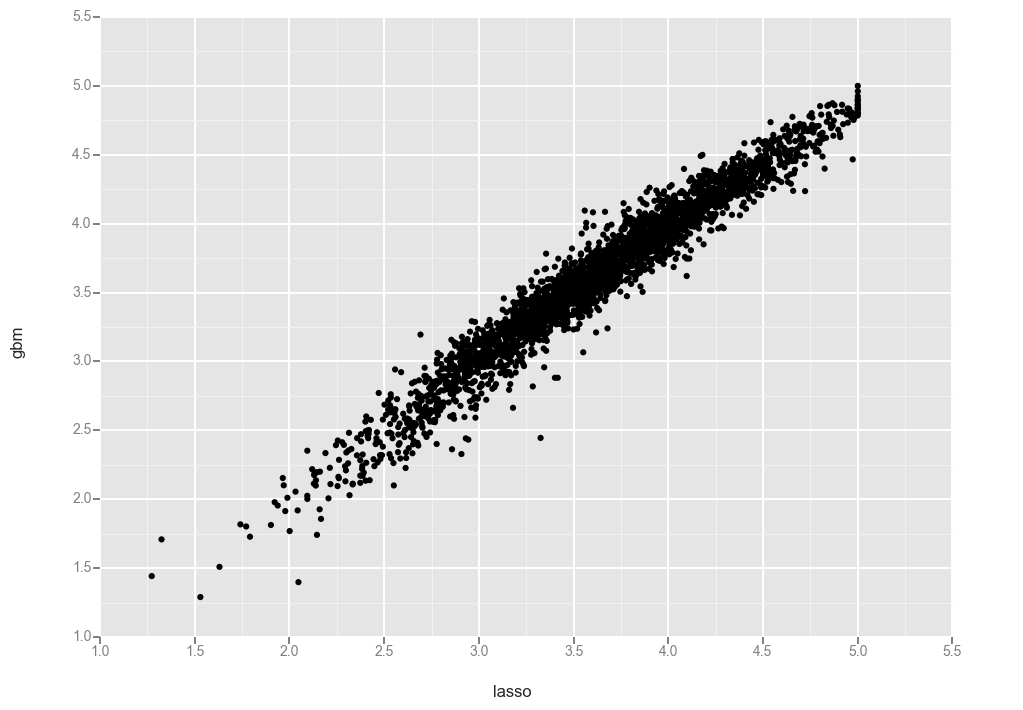

<ggplot: (-9223372036557954749)>

In [72]:
ggplot(results, aes('lasso', 'gbm')) + geom_point()

In [80]:
best_ = pd.read_csv("Predictions/Prediction_26_4.csv", names=['pred'])
best_.head()

,pred
0,4.957861
1,4.961601
2,3.082699
3,3.157656
4,3.265423


In [81]:
best_['lasso'] = results.lasso
best_['gbm'] = results.gbm
best_['both'] = results.both
# best_['mean'] = (best_.old + best_.new) / 2

In [82]:
best_.corr()

,pred,lasso,gbm,both
pred,1.000000,0.992817,0.978096,0.991799
lasso,0.992817,1.000000,0.974687,0.993732
gbm,0.978096,0.974687,1.000000,0.993571
both,0.991799,0.993732,0.993571,1.000000


In [85]:
pd.melt(best_, id_vars='pred', value_vars=['lasso', 'both']).head()

,pred,variable,value
0,4.957861,lasso,5.000000
1,4.961601,lasso,5.000000
2,3.082699,lasso,3.025586
3,3.157656,lasso,3.187230
4,3.265423,lasso,3.229997


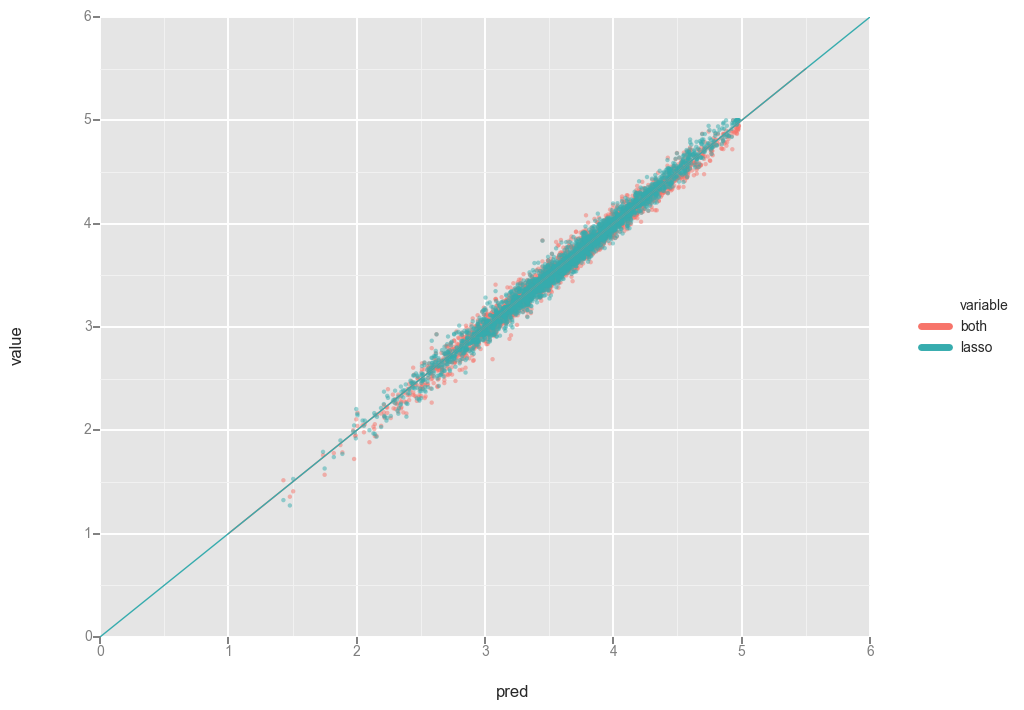

<ggplot: (288036493)>

In [87]:
ggplot(pd.melt(best_, id_vars='pred', value_vars=['lasso', 'both']), 
       aes('pred', 'value', color = 'variable')) +\
    geom_point(alpha = .5, size = 10) +\
    geom_abline() +\
    xlim(0, 6) +\
    ylim(0, 6)

In [89]:
### EXPORT
results[['both']].to_csv("Predictions/Prediction_17_5.csv", index = False)

### Prediction 25/5

In [175]:
##################################
# Add new features and Fix nulls #
##################################

## New Features
X_train_full = new_features(X_train, X_train_dates, y_train_dates)
X_test_full = new_features(X_test, X_test_dates, y_test_dates)
## Fix Nulls in test and train
X_train['set'] = 'train'
X_test['set'] = 'test'
all_rankings_data = X_train.append(X_test, ignore_index = True)
# imputation over full data using lasso
X_rankings_imp = test_predictive_imputer(all_rankings_data[titles.title].replace(0, np.nan))
# full data with new features
X_full = X_train_full.append(X_test_full, ignore_index=True)
# full data with new features + na fix
new_features_ = [col for col in X_train_full.columns if col not in X_train_na_fix.columns]
full_data_imp = pd.concat([X_rankings_imp.reset_index(drop = True), 
                           X_full[new_features_].reset_index(drop = True)], axis = 1)
# drop set var
# full_data_imp.drop(['set'], axis = 1, inplace = True)
# scaled
X_full_imp_scaled = pd.DataFrame(StandardScaler().fit_transform(full_data_imp), 
                                 columns = full_data_imp.columns)

X_train_na_fix_full_scaled = X_full_imp_scaled.loc[all_rankings_data.set == 'train']
X_test_na_fix_full_scaled = X_full_imp_scaled.loc[all_rankings_data.set == 'test']

In [274]:
# X_full_imp_scaled.head()

In [275]:
# full_data_imp.head()

In [177]:
lasso_model = LassoCV(n_alphas = 100, max_iter = 5000)
lasso_model_fit = lasso_model.fit(X_train_na_fix_full_scaled, y_train_full.values.ravel())

lasso_test_pred = lasso_model_fit.predict(X_test_na_fix_full_scaled)

lasso_test_pred[lasso_test_pred > 5] = 5
lasso_test_pred[lasso_test_pred < 1] = 1

In [269]:
coefs_ = pd.DataFrame({'coef':lasso_model_fit.coef_, 'coef_abs':abs(lasso_model_fit.coef_),
                       'name':X_train_na_fix_full_scaled.columns})
coefs_.sort_values('coef_abs', ascending = False).head(10)

,coef,coef_abs,name
206,0.168566,0.168566,similar_mean
34,0.107133,0.107133,Two Weeks Notice
32,0.084836,0.084836,Sister Act
48,0.071102,0.071102,The Wedding Planner
119,0.051781,0.051781,Two Weeks Notice_is_rate
68,0.049749,0.049749,Erin Brockovich
33,0.046172,0.046172,Double Jeopardy
208,0.044269,0.044269,similar_number
73,0.041391,0.041391,Tomb Raider
9,0.041380,0.041380,Sweet Home Alabama


In [180]:
gbm_model = GradientBoostingRegressor(learning_rate=.025, n_estimators=500)
gbm_model_fit = gbm_model.fit(X_train_na_fix_full_scaled, 
                              y_train_full.values.ravel())

gbm_test_pred = gbm_model_fit.predict(X_test_na_fix_full_scaled)

gbm_test_pred[gbm_test_pred > 5] = 5
gbm_test_pred[gbm_test_pred < 1] = 1

In [305]:
coefs_gbm = pd.DataFrame({'coef':gbm_model_fit.feature_importances_,
                           'name':X_train_na_fix_full_scaled.columns
                         })
coefs_gbm.sort_values('coef', ascending = False).head(10)

,coef,name
206,0.088700,similar_mean
34,0.035859,Two Weeks Notice
32,0.028901,Sister Act
207,0.027132,similar_sd
68,0.021790,Erin Brockovich
188,0.021512,sd_of_ratings_per_user
33,0.021430,Double Jeopardy
191,0.018815,days_since_first_rating
73,0.018440,Tomb Raider
217,0.017851,date_year_corr


In [197]:
results_25_5 = pd.DataFrame({'lasso':lasso_test_pred, 'gbm':gbm_test_pred})
results_25_5['both'] = results_25_5.mean(axis = 1)
results_25_5.head(10)

,gbm,lasso,both
0,4.853561,5.000000,4.926781
1,4.916333,5.000000,4.958166
2,3.010576,3.012111,3.011343
3,3.213871,3.235880,3.224876
4,3.168128,3.215880,3.192004
5,3.232734,3.077963,3.155349
6,4.109194,4.265034,4.187114
7,4.283408,4.188565,4.235986
8,3.419241,3.394865,3.407053
9,2.871905,2.818620,2.845263


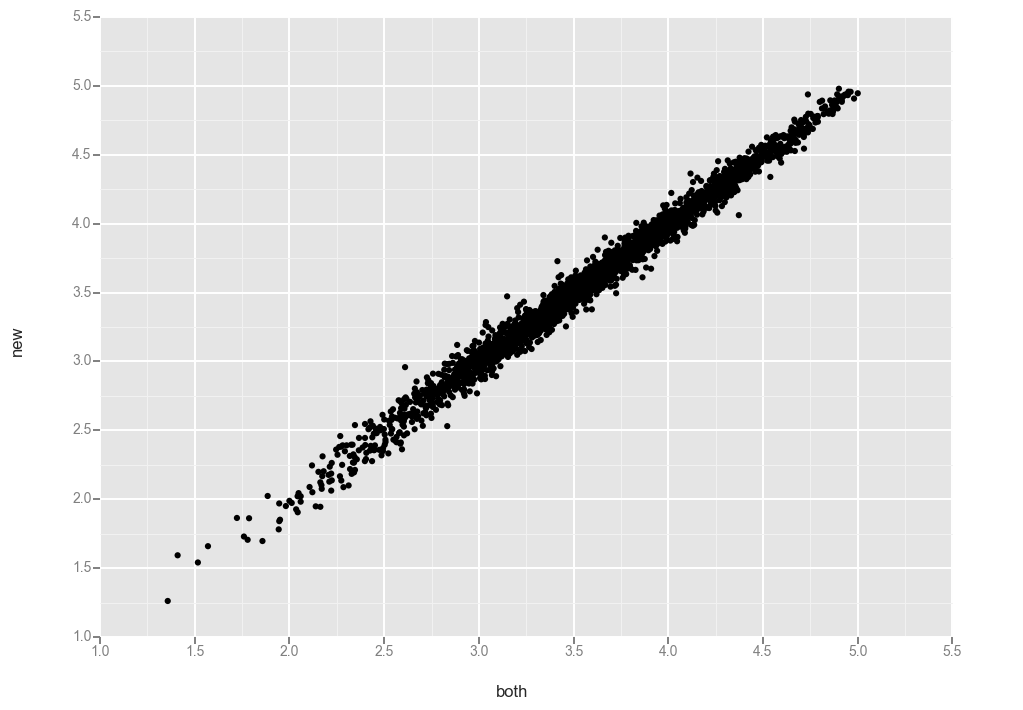

<ggplot: (-9223372036548010429)>

In [191]:
t_p = results[['both']].copy()
t_p['new'] = results_25_5.both
ggplot(t_p, aes('both', 'new')) + geom_point()

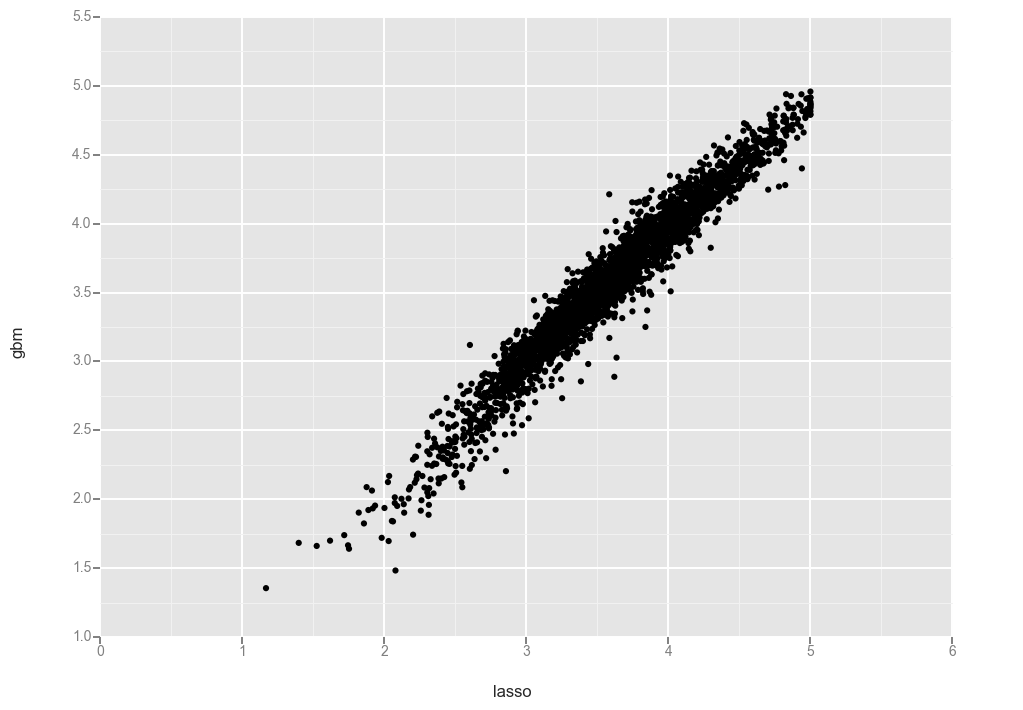

<ggplot: (328105543)>

In [270]:
ggplot(results_25_5, aes('lasso', 'gbm')) + geom_point()

In [192]:
t_p.corr()

,both,new
both,1.000000,0.993655
new,0.993655,1.000000


In [193]:
results_25_5[['both']].to_csv("Predictions/Prediction_25_5.csv", index = False)

### Prediction 1/6

In [418]:
grid_for_lasso = np.arange(.0001, .01, .0001)
grid_for_ridge = np.arange(2065, 2097, .5)

In [407]:
lasso_model = LassoCV(alphas = grid_for_lasso, max_iter = 5000, cv = 20)
lasso_model_fit = lasso_model.fit(X_train_na_fix_full_scaled, y_train_full.values.ravel())

lasso_test_pred = lasso_model_fit.predict(X_test_na_fix_full_scaled)

lasso_test_pred[lasso_test_pred > 5] = 5
lasso_test_pred[lasso_test_pred < 1] = 1

In [408]:
lasso_model.alpha_

0.0055000000000000005

In [409]:
coefs_ = pd.DataFrame({'coef':lasso_model_fit.coef_, 'coef_abs':abs(lasso_model_fit.coef_),
                       'name':X_train_na_fix_full_scaled.columns})
coefs_.sort_values('coef_abs', ascending = False).head(10)

,coef,coef_abs,name
206,0.167214,0.167214,similar_mean
34,0.108143,0.108143,Two Weeks Notice
32,0.085098,0.085098,Sister Act
48,0.072462,0.072462,The Wedding Planner
119,0.053573,0.053573,Two Weeks Notice_is_rate
68,0.050924,0.050924,Erin Brockovich
33,0.046290,0.046290,Double Jeopardy
73,0.041801,0.041801,Tomb Raider
9,0.041675,0.041675,Sweet Home Alabama
208,0.041497,0.041497,similar_number


In [419]:
ridge_model = RidgeCV(alphas = grid_for_ridge, cv = 20)
ridge_model_fit = ridge_model.fit(X_train_na_fix_full_scaled, y_train_full.values.ravel())

ridge_test_pred = ridge_model_fit.predict(X_test_na_fix_full_scaled)

ridge_test_pred[ridge_test_pred > 5] = 5
ridge_test_pred[ridge_test_pred < 1] = 1

In [420]:
ridge_model_fit.alpha_

2075.0

In [421]:
coefs_ridge = pd.DataFrame({'coef':ridge_model_fit.coef_, 'coef_abs':abs(ridge_model_fit.coef_),
                       'name':X_train_na_fix_full_scaled.columns})
coefs_ridge.sort_values('coef_abs', ascending = False).head(10)

,coef,coef_abs,name
34,0.101116,0.101116,Two Weeks Notice
32,0.080526,0.080526,Sister Act
206,0.077342,0.077342,similar_mean
48,0.074102,0.074102,The Wedding Planner
9,0.054787,0.054787,Sweet Home Alabama
119,0.050152,0.050152,Two Weeks Notice_is_rate
68,0.048610,0.048610,Erin Brockovich
33,0.041635,0.041635,Double Jeopardy
117,0.038714,0.038714,Sister Act_is_rate
73,0.038303,0.038303,Tomb Raider


In [423]:
####################
# find best params #
####################
mod_gbm = GradientBoostingRegressor()
params = {'learning_rate':[.05, .025, .01], 'n_estimators':[100,  300, 500, 600], 'max_depth':[2, 3, 4]}

grid_search_gbm = GridSearchCV(mod_gbm, param_grid = params, cv = 5, refit = False)

grid_search_gbm.fit(X_train_na_fix_full_scaled, y_train_full.values.ravel())

grid_search_gbm.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}

In [429]:
mod_gbm = GradientBoostingRegressor()
params = {'learning_rate':[.05, .075, .1], 'n_estimators':[500], 'max_depth':[2, 3]}

grid_search_gbm = GridSearchCV(mod_gbm, param_grid = params, cv = 5, refit = False)

grid_search_gbm.fit(X_train_na_fix_full_scaled, y_train_full.values.ravel())

grid_search_gbm.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}

In [450]:
cv = 10

cv_results = cross_val_score(
                            GradientBoostingRegressor(learning_rate = .025, n_estimators = 500, max_depth = 3), 
                            scaled_lasso_imp,
                            y_train_full.values.ravel(), 
                            scoring = "neg_mean_squared_error", 
                            cv = cv)

In [451]:
# result for 10-fold cv with {'learning_rate': 0.025, 'max_depth': 3, 'n_estimators': 500}
np.sqrt(cv_results * (-1)).mean()

0.7600828653379248

In [428]:
# result for 10-fold cv with {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}
np.sqrt(cv_results * (-1)).mean()

0.76016794936915955

In [452]:
gbm_model = GradientBoostingRegressor(learning_rate = .025, n_estimators = 500, max_depth = 3)
gbm_model_fit = gbm_model.fit(X_train_na_fix_full_scaled, 
                              y_train_full.values.ravel())

gbm_test_pred = gbm_model_fit.predict(X_test_na_fix_full_scaled)

gbm_test_pred[gbm_test_pred > 5] = 5
gbm_test_pred[gbm_test_pred < 1] = 1

In [453]:
coefs_gbm = pd.DataFrame({'coef':gbm_model_fit.feature_importances_,
                           'name':X_train_na_fix_full_scaled.columns
                         })
coefs_gbm.sort_values('coef', ascending = False).head(10)

,coef,name
206,0.088494,similar_mean
34,0.035850,Two Weeks Notice
32,0.028914,Sister Act
207,0.027166,similar_sd
68,0.021907,Erin Brockovich
188,0.021512,sd_of_ratings_per_user
33,0.021437,Double Jeopardy
191,0.018815,days_since_first_rating
73,0.018462,Tomb Raider
217,0.017851,date_year_corr


In [467]:
results_1_6 = pd.DataFrame({'lasso':lasso_test_pred, 'gbm':gbm_test_pred,
                            'ridge':ridge_test_pred})
results_1_6['mean_'] = results_1_6.mean(axis = 1)
results_1_6.head(10)

,gbm,lasso,ridge,mean_
0,4.853561,5.000000,4.982684,4.945415
1,4.916333,5.000000,5.000000,4.972111
2,3.010576,3.010617,3.071608,3.030934
3,3.213871,3.233913,3.207897,3.218560
4,3.168128,3.213640,3.184192,3.188653
5,3.232734,3.078222,3.048341,3.119766
6,4.109194,4.277450,4.138396,4.175013
7,4.283408,4.182585,4.252051,4.239348
8,3.419241,3.390985,3.393102,3.401109
9,2.871905,2.819116,2.825071,2.838698


In [469]:
results_1_6['weighted_mean_'] = (results_1_6['lasso'] + results_1_6['gbm']) * .4 + results_1_6['ridge'] * .2
results_1_6.head(10)

,gbm,lasso,ridge,mean_,weighted_mean_
0,4.853561,5.000000,4.982684,4.945415,4.937961
1,4.916333,5.000000,5.000000,4.972111,4.966533
2,3.010576,3.010617,3.071608,3.030934,3.022799
3,3.213871,3.233913,3.207897,3.218560,3.220693
4,3.168128,3.213640,3.184192,3.188653,3.189546
5,3.232734,3.078222,3.048341,3.119766,3.134050
6,4.109194,4.277450,4.138396,4.175013,4.182337
7,4.283408,4.182585,4.252051,4.239348,4.236807
8,3.419241,3.390985,3.393102,3.401109,3.402711
9,2.871905,2.819116,2.825071,2.838698,2.841423


In [470]:
results_1_6.loc[(results_1_6.lasso - results_1_6.gbm) > .7]

,gbm,lasso,ridge,mean_,weighted_mean_
1053,2.888627,3.621492,3.675316,3.395145,3.339111


In [471]:
results_1_6.loc[(results_1_6.lasso - results_1_6.ridge) > .2]

,gbm,lasso,ridge,mean_,weighted_mean_
142,2.789434,2.772295,2.492887,2.684872,2.723269
392,3.880412,3.780815,3.558169,3.739799,3.776125
821,1.660905,1.485696,1.187442,1.444681,1.496129
1525,3.946827,3.923335,3.686949,3.852370,3.885454
1828,3.986548,3.932184,3.725896,3.881543,3.912672
2711,4.156104,3.981910,3.768366,3.968793,4.008879
2848,2.734985,2.435987,2.215643,2.462205,2.511517


In [472]:
results_1_6.corr()

,gbm,lasso,ridge,mean_,weighted_mean_
gbm,1.000000,0.974150,0.968834,0.987621,0.990253
lasso,0.974150,1.000000,0.995313,0.996737,0.995799
ridge,0.968834,0.995313,1.000000,0.995001,0.992749
mean_,0.987621,0.996737,0.995001,1.000000,0.999791
weighted_mean_,0.990253,0.995799,0.992749,0.999791,1.000000


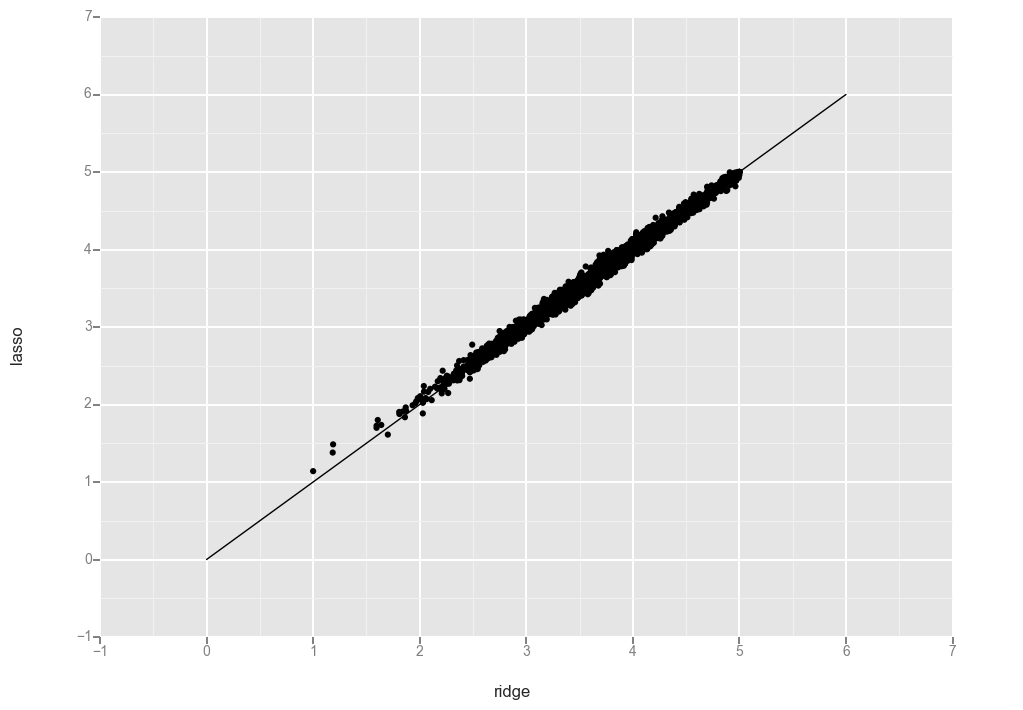

<ggplot: (-9223372036510944014)>

In [473]:
ggplot(results_1_6, aes('ridge', 'lasso')) + geom_point() + geom_abline()

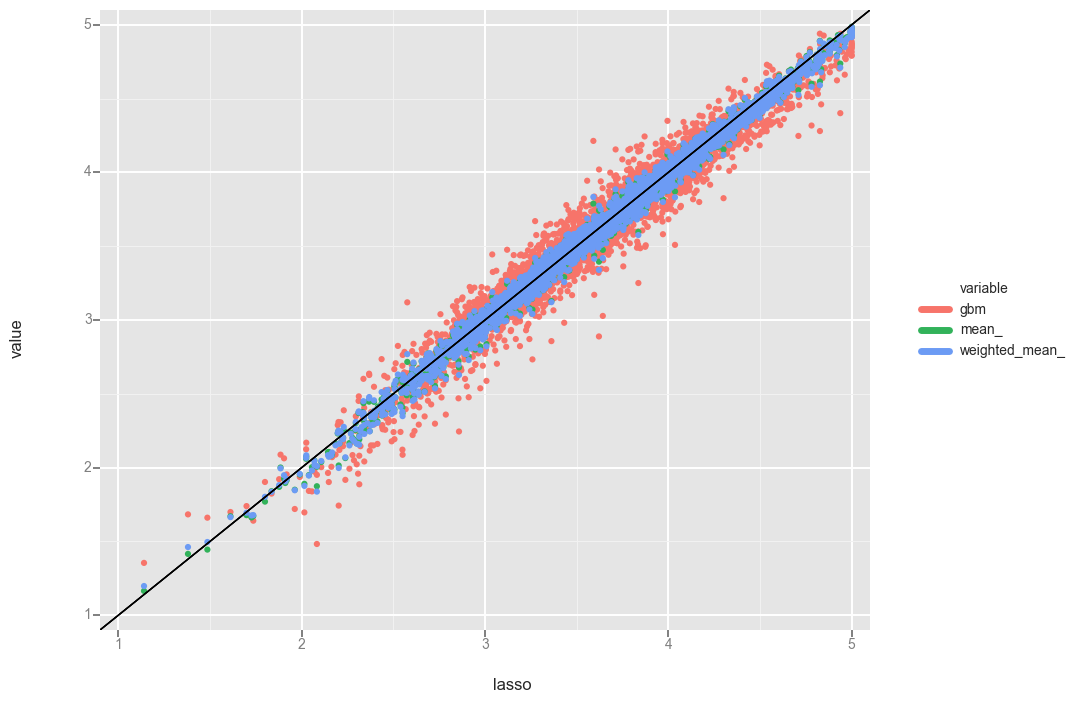

<ggplot: (350824133)>

In [474]:
ggplot(pd.melt(results_1_6[['gbm', 'lasso', 'mean_', 'weighted_mean_']], id_vars = 'lasso'), 
       aes('lasso', 'value', color = 'variable')) +\
    geom_point(alpha = 1) +\
    geom_abline(color = 'black') +\
    xlim(.9, 5.1) +\
    ylim(.9, 5.1)

In [475]:
###### Export
results_1_6[['mean_']].to_csv("Predictions/Prediction_1_6.csv", index = False)

## Data Exploration & Visualisation

[Top](#Navigation)

In [40]:
# change to a long format
X_train_for_vis = X_train.copy()
X_train_dates_for_vis = X_train_dates.copy()
X_train_for_vis['user_id'] = range(X_train_for_vis.shape[0])
X_train_dates_for_vis['user_id'] = range(X_train_for_vis.shape[0])

In [41]:
X_train_for_vis_melted = pd.melt(X_train_for_vis, id_vars=['user_id'])
X_train_for_vis_melted.columns = ['user_id', 'movie', 'rating']
X_train_dates_for_vis_melted = pd.melt(X_train_dates_for_vis, id_vars=['user_id'])
X_train_dates_for_vis_melted.columns = ['user_id', 'movie', 'date']

In [42]:
all_train_data_for_vis = X_train_for_vis_melted.merge(X_train_dates_for_vis_melted, 
                                                      on = ['user_id', 'movie'])

In [43]:
all_train_data_for_vis.head()

,user_id,movie,rating,date
0,0,Independence Day,4,2544
1,1,Independence Day,4,2656
2,2,Independence Day,5,2381
3,3,Independence Day,5,1404
4,4,Independence Day,5,2428


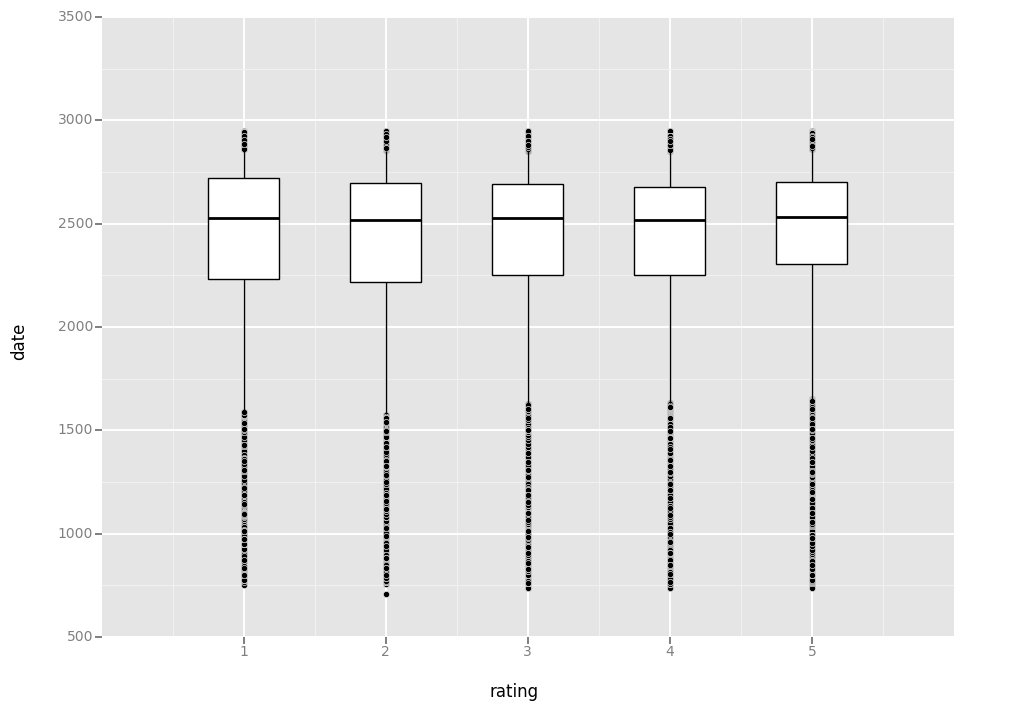

<ggplot: (-9223372036564130928)>

In [36]:
ggplot(all_train_data_for_vis.loc[all_train_data_for_vis.rating != 0], 
       aes('rating', 'date')) + geom_boxplot()

In [37]:
# correlation netween date and rating
tmp = all_train_data_for_vis.loc[all_train_data_for_vis.rating != 0]
np.corrcoef(tmp.rating, tmp.date)

array([[ 1.        ,  0.02678506],
       [ 0.02678506,  1.        ]])

In [723]:
# same date ratings...
tmp_date = X_train_dates.copy()
tmp_date['y_dates'] = y_train_dates

tmp = tmp_date.apply(lambda x : sum(x == x.y_dates) - 1, axis = 1)

In [724]:
# pct of user with ratings at same date of our movie - train data
(tmp > 0).mean()

0.0264

In [53]:
tmp.mean()

1.0851

In [55]:
# tmp[tmp > 1]

In [60]:
# X_train.iloc[496][X_train_dates.iloc[496] == 2354]

In [49]:
# same date ratings...
tmp_test_date = X_test_dates.copy()
tmp_test_date['y_dates'] = y_test_dates
# pct of user with ratings at same date of our movie - test data
(tmp_test_date.apply(lambda x : sum(x == x.y_dates), axis = 1) > 1).mean()

0.93039918116683729

In [52]:
tmp_test_date.apply(lambda x : sum(x == x.y_dates), axis = 1).mean()

21.24292050494712

In [ ]:
tmp_test_date.apply(lambda x : sum(x == x.y_dates), axis = 1).mean()

In [68]:
X_test.std(axis = 1).mean()

1.5677731199154123

In [92]:
same_date_rating = X_train_dates.apply(lambda x : x == y_train_dates.V1)

In [121]:
t = X_train[same_date_rating]
tt = t.mean(axis=1)
mean_ = tt[tt.notnull()]
count_ = t.count(axis = 1)
count_ = count_[count_ != 0]
std_ = t.std(axis = 1)
std_ = std_[std_.notnull()]

In [151]:
tmp_ = pd.DataFrame({'count':count_, 'mean':mean_, 'sd':std_})
tmp_.loc[tmp_['count'] > 5].shape

(36, 3)

In [152]:
tmp_.loc[tmp_['count'] > 5].sd.mean()

0.848490155988306

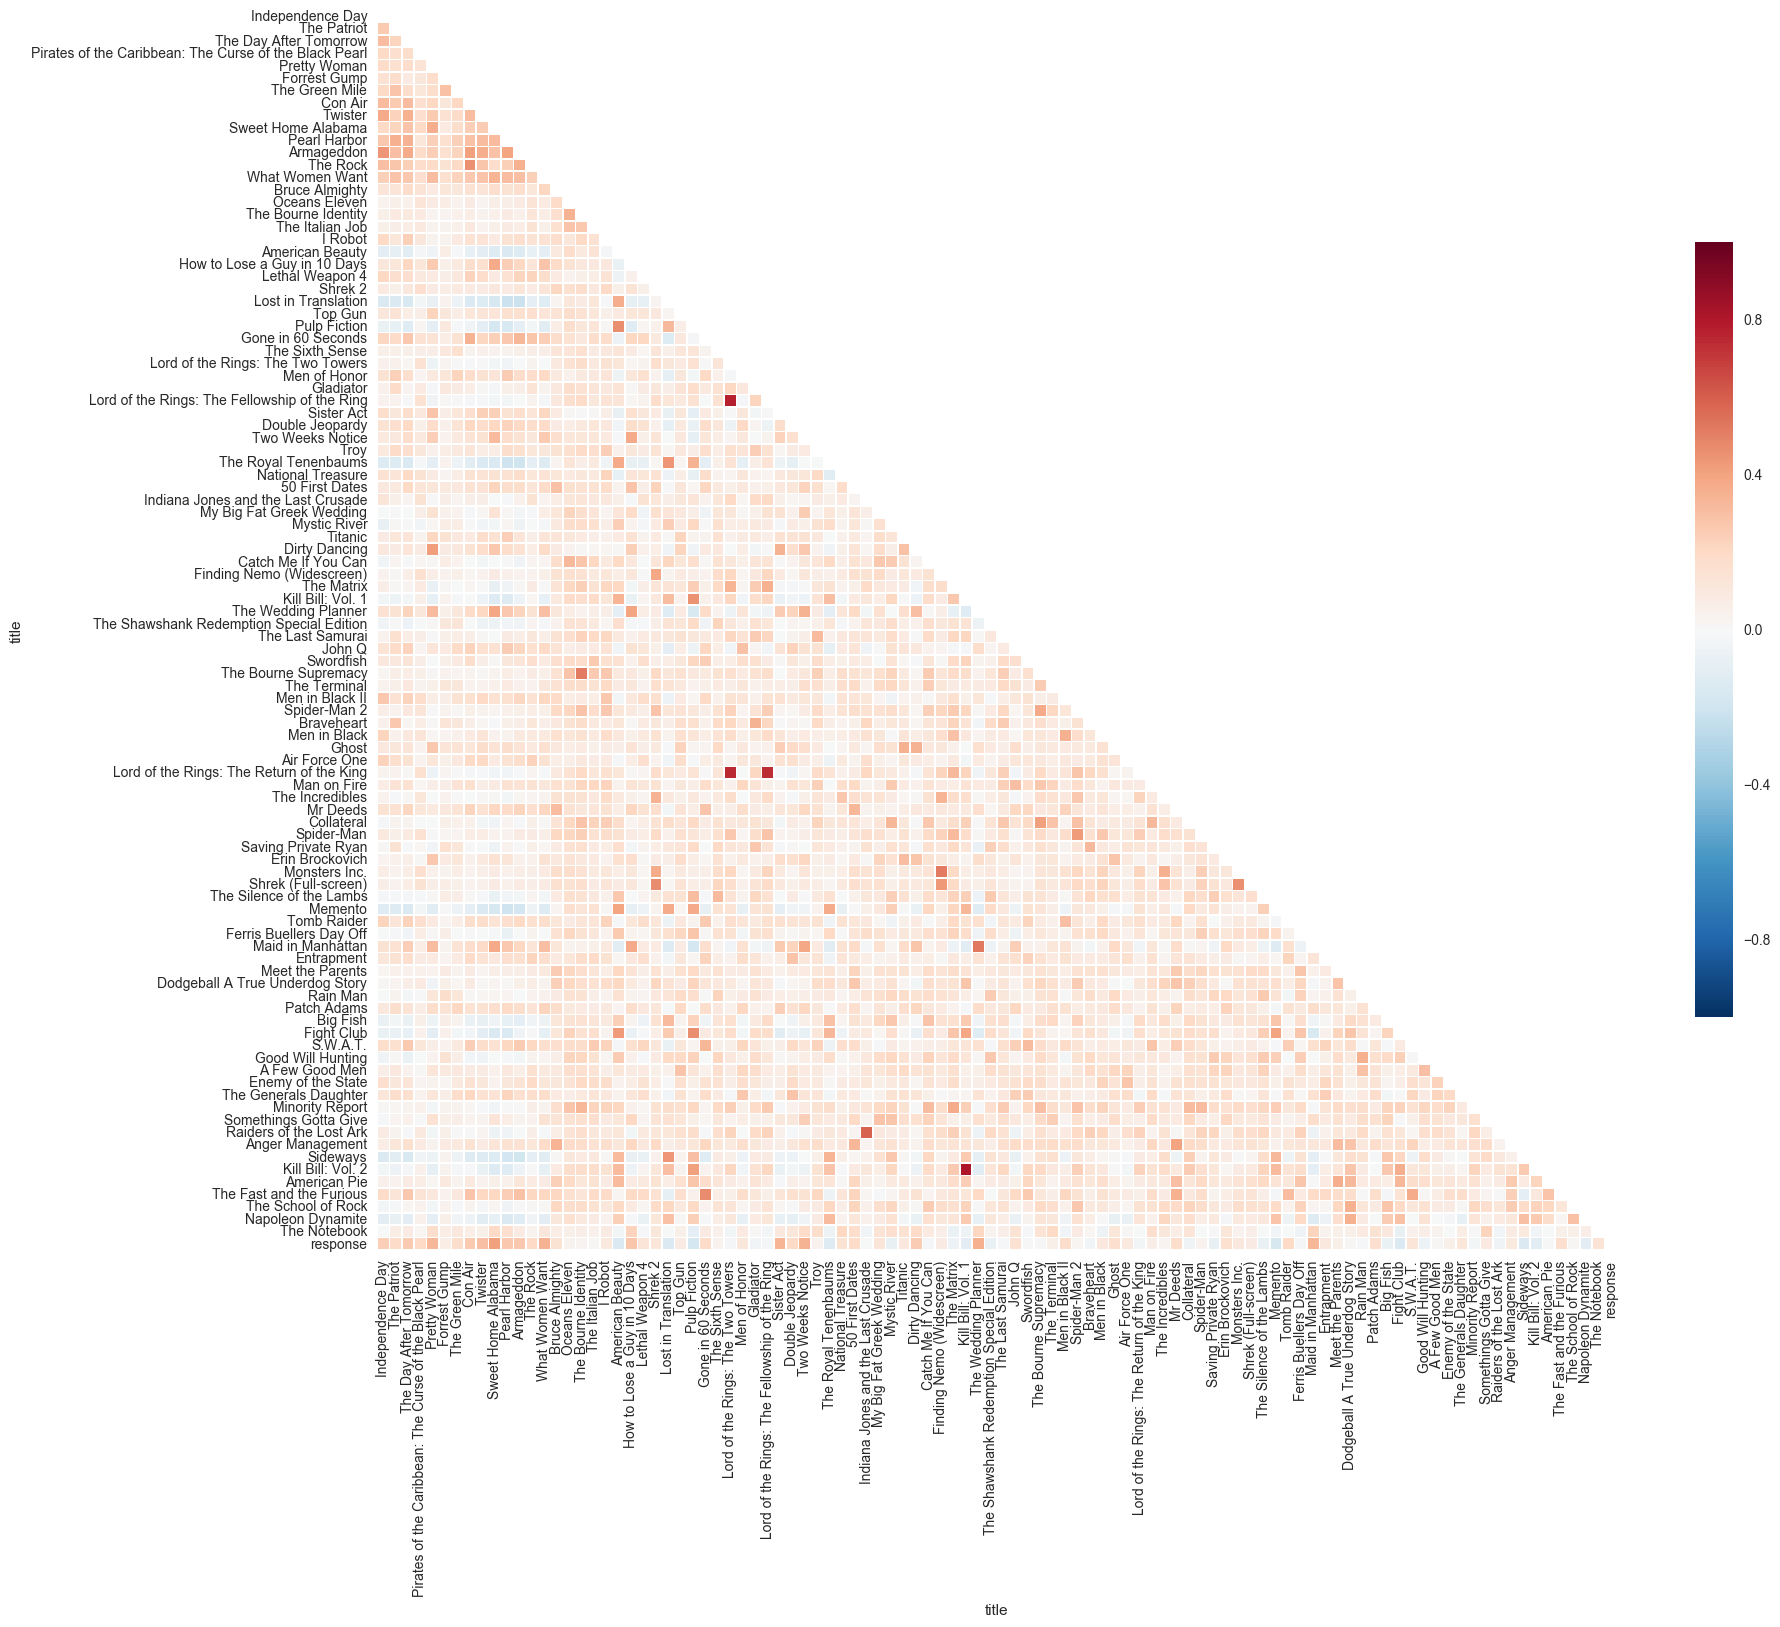

In [7]:
## Corr plot
sns.set(style = "white")

# Compute the correlation matrix
corr_tmp = X_train.copy()
corr_tmp['response'] = y_train_full.V1
corr = corr_tmp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, # cmap = cmap,
            square = True, linewidths=.5, 
            cbar_kws={"shrink": .5})
plt.show()

In [257]:
similar_movies = corr.response[(corr.response > .3) & (corr.response < 1)].index.tolist()
similar_movies

['Pretty Woman',
 'Twister',
 'Sweet Home Alabama',
 'What Women Want',
 'Sister Act',
 'Two Weeks Notice',
 'The Wedding Planner',
 'Maid in Manhattan']

In [54]:
dissimilar_movies = corr.response[(corr.response < -.1)].index.tolist()
dissimilar_movies

['American Beauty',
 'Lost in Translation',
 'Pulp Fiction',
 'The Royal Tenenbaums',
 'Kill Bill: Vol. 1',
 'Memento',
 'Fight Club',
 'Sideways',
 'Kill Bill: Vol. 2',
 'Napoleon Dynamite']

In [247]:
# o = t[similar_movies].mean(axis = 1)
# o[o.notnull()].reset_index()

In [248]:
# t['Sister Act'][t['Sister Act'].notnull()]

In [262]:
ttt = X_train.copy()
ttt['new'] = ttt[similar_movies].apply(lambda x : np.mean(x[x!=0]), axis = 1)

In [263]:
np.sqrt(mean_squared_error(y_train_full.V1, ttt['new']))

0.79284058255263634

In [24]:
tttt = X_train.where(X_train_dates.apply(lambda x : x == y_train_dates.V1))[similar_movies].mean(axis = 1)
tttt[tttt.notnull()]

320     3.000000
850     4.428571
1169    3.000000
1607    2.500000
1650    3.500000
1691    5.000000
1720    5.000000
2009    5.000000
2042    4.000000
2068    2.000000
3052    3.000000
3140    4.000000
3253    4.000000
4345    4.000000
4914    5.000000
6316    4.000000
7099    4.333333
7170    4.000000
7456    5.000000
7475    3.000000
7594    4.166667
7619    4.000000
7629    3.000000
7753    3.500000
7940    3.500000
8141    4.000000
8250    3.000000
8756    4.000000
9253    4.000000
9377    5.000000
9855    3.000000
dtype: float64

In [45]:
tmp__ = pd.DataFrame({'date':y_train_dates.V1, 'rate':y_train_full.V1})
# ggplot(tmp__.groupby('date').mean().reset_index(), aes('rate', 'date')) + geom_point()
tmp___ = tmp__.pivot_table(values = 'rate', index='date', aggfunc = [len, np.mean])

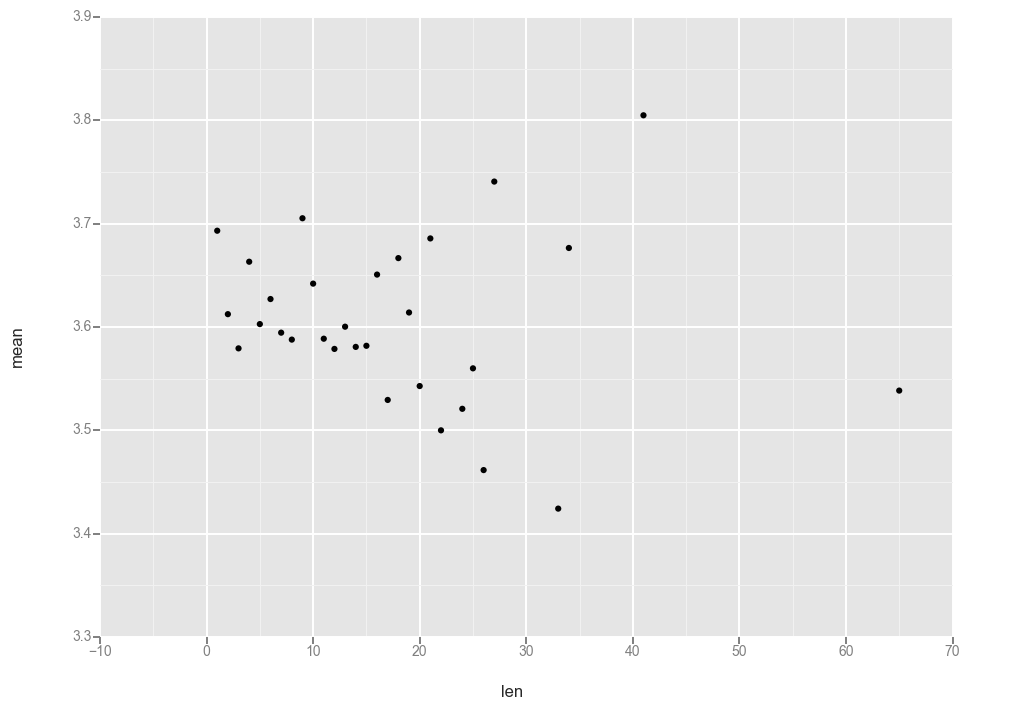

<ggplot: (-9223372036561072629)>

In [48]:
ggplot(tmp___.groupby('len')['mean'].mean().reset_index(), aes('len', 'mean')) + geom_point()

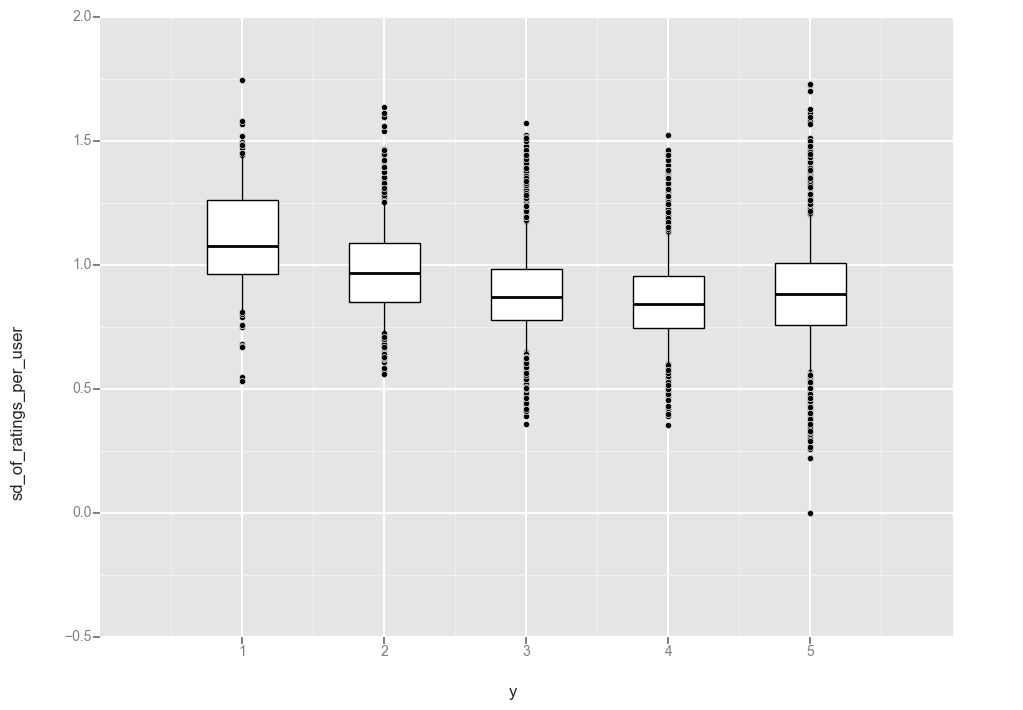

<ggplot: (-9223372036559876166)>

In [73]:
tmp_ = X_train_full_na_fix[['sd_of_ratings_per_user']].copy()
tmp_['y'] = y_train_full
ggplot(tmp_, aes('y', 'sd_of_ratings_per_user')) + geom_boxplot()

In [74]:
np.corrcoef(tmp_.sd_of_ratings_per_user, tmp_.y)

array([[ 1.        , -0.17450357],
       [-0.17450357,  1.        ]])

In [99]:
tmp__ = X_train_simple_na_fix[similar_movies].apply(lambda x:np.std(x[x!=0]), axis = 1).reset_index()
tmp__['y'] = y_train_full

In [100]:
tmp__.drop(['index'], axis = 1, inplace = 1)
tmp__.columns = ['std', 'rate']
tmp__.head()

,std,rate
0,0.968246,4
1,0.695971,3
2,0.599479,3
3,0.695971,5
4,1.408678,5


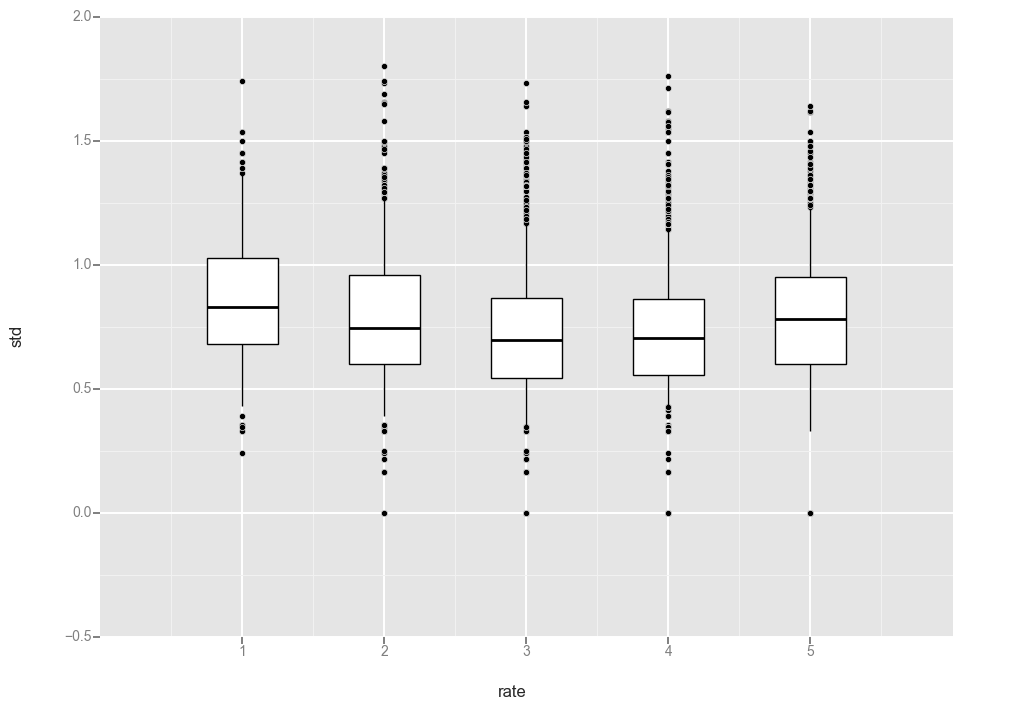

<ggplot: (297629290)>

In [101]:
ggplot(tmp__, aes('rate', 'std')) + geom_boxplot()

In [102]:
np.corrcoef(tmp__['std'], tmp__.rate)

array([[ 1.       , -0.0246722],
       [-0.0246722,  1.       ]])

In [91]:
(X_train == 0).sum().sum() / float(X_train.shape[0] * X_train.shape[1])

0.15471010101010102

In [103]:
X_train_full_na_fix.head()

title,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,...,sd_of_ratings_per_user,days_since_first_rating,num_same_date_ratings,similar_mean,similar_sd,similar_number,avg_ratings_before,num_ratings_before,avg_ratings_after,num_ratings_after
0,4,4,3,5,4,5,4,4,5,4,...,0.651683,-442,0,3.750,0.968246,8,2.500000,0,4.444444,90
1,4,5,3,3,4,3,4,4,3,2,...,0.850087,-801,0,3.250,0.829156,4,2.500000,0,3.440476,84
2,5,5,5,5,4,5,4,3,4,5,...,0.563166,315,0,4.125,0.599479,8,4.587302,63,4.750000,12
3,5,5,5,5,4,5,5,3,4,5,...,0.916852,1219,0,4.375,0.695971,8,4.345679,81,4.111111,9
4,5,5,5,5,5,5,5,5,5,5,...,1.367927,345,0,3.375,1.408678,8,4.240000,50,3.350000,20


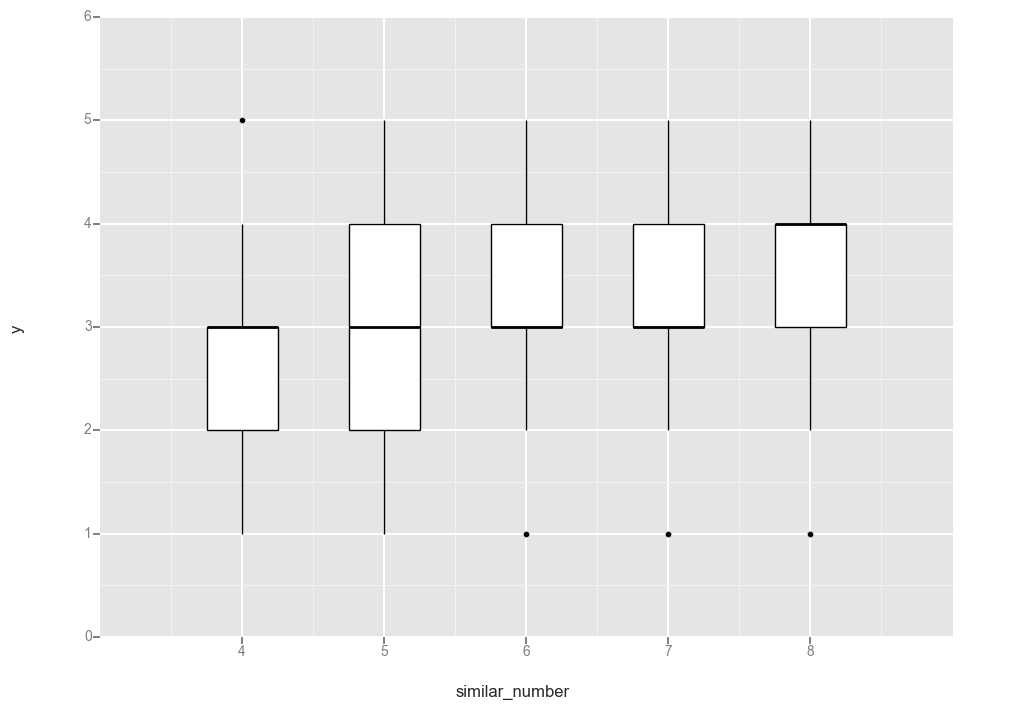

<ggplot: (294886804)>

In [135]:
to_plot = X_train_full_na_fix[['similar_number', 'similar_sd', 'similar_mean',
                               'dissimilar_number', 'dissimilar_sd', 'dissimilar_mean']].copy()
to_plot['y'] = y_train_full
ggplot(to_plot, aes('similar_number', 'y')) + geom_boxplot()

In [108]:
to_plot.groupby('similar_number')['y'].mean()

similar_number
4    2.771429
5    3.056893
6    3.279092
7    3.454098
8    3.797341
Name: y, dtype: float64

In [136]:
to_plot.groupby('dissimilar_number')['y'].mean()

dissimilar_number
0     4.012121
1     4.032491
2     3.921114
3     3.855721
4     3.828146
5     3.822563
6     3.708297
7     3.640862
8     3.506155
9     3.451635
10    3.268923
Name: y, dtype: float64

In [111]:
np.corrcoef(to_plot.similar_mean, to_plot.y)

array([[ 1.        ,  0.57051404],
       [ 0.57051404,  1.        ]])

In [141]:
np.corrcoef(to_plot.dissimilar_number, to_plot.y)

array([[ 1.        , -0.22194021],
       [-0.22194021,  1.        ]])

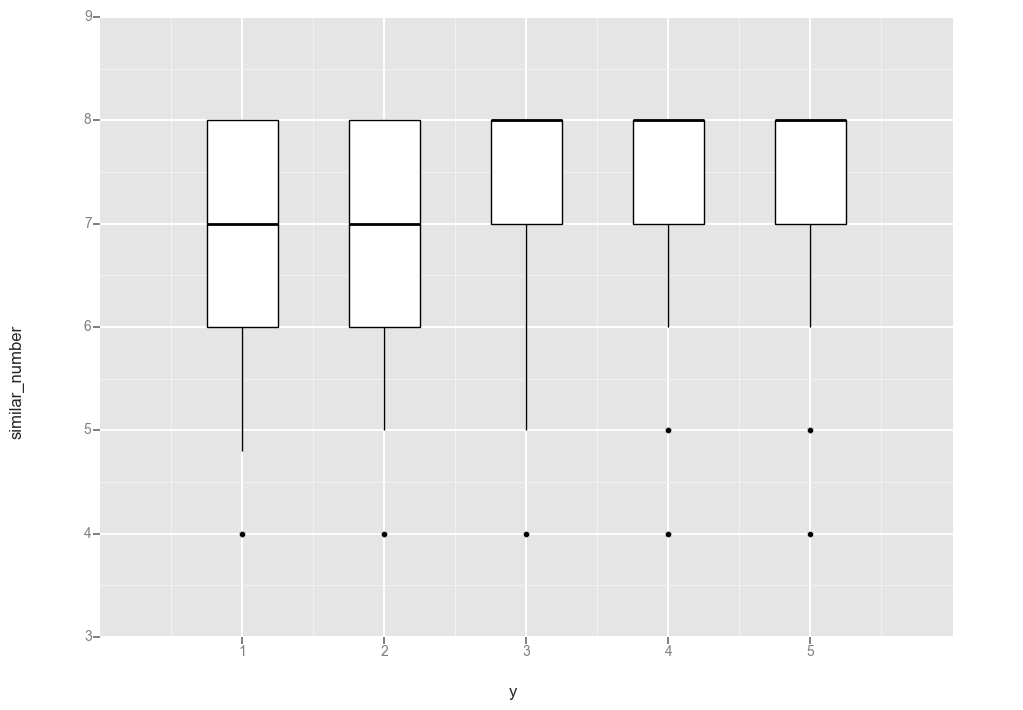

<ggplot: (-9223372036560736610)>

In [144]:
ggplot(to_plot, aes('y', 'similar_number')) + geom_boxplot()

In [154]:
tmp = X_train.copy()
tmp = pd.DataFrame(StandardScaler().fit_transform(tmp), columns = X_train.columns)
tmp = tmp.apply(lambda x : cosine(x, y_train_full))

In [159]:
dissimilar_movies

['American Beauty',
 'Lost in Translation',
 'Pulp Fiction',
 'The Royal Tenenbaums',
 'Kill Bill: Vol. 1',
 'Memento',
 'Fight Club',
 'Sideways',
 'Kill Bill: Vol. 2',
 'Napoleon Dynamite']

In [ ]:
## cosine similarity

In [160]:
tmp.sort_values().tail(10)

title
Napoleon Dynamite       1.026871
Kill Bill: Vol. 1       1.028025
Kill Bill: Vol. 2       1.028274
The Royal Tenenbaums    1.032470
American Beauty         1.037457
Fight Club              1.038851
Sideways                1.038936
Lost in Translation     1.040118
Memento                 1.043969
Pulp Fiction            1.045570
dtype: float64

In [222]:
tmp = X_train_dates[similar_movies].apply(lambda x : x == y_train_dates.V1).sum(axis = 1).\
    reset_index().rename(columns = {0:'number'})
tmp.loc[tmp.number > 0].shape

(31, 2)

In [229]:
t = X_train[similar_movies].where(X_train_dates.apply(lambda x : x == y_train_dates.V1)).mean(axis=1)
t = pd.DataFrame(t, columns = ['mean'])
t['y'] = y_train_full

In [234]:
np.corrcoef(t.loc[t['mean'].notnull(), 'mean'], t.loc[t['mean'].notnull(), 'y'])

array([[ 1.       ,  0.3462373],
       [ 0.3462373,  1.       ]])

In [433]:
titles.head()

,date,title
0,1996,Independence Day
1,2000,The Patriot
2,2004,The Day After Tomorrow
3,2003,Pirates of the Caribbean: The Curse of the Bla...
4,1990,Pretty Woman


In [ ]:
tmp = X_train_dates.replace(0, np.nan).copy()
for col in X_train_dates.columns:
    tmp[col] = ((tmp[col] // 365 + 1999) - titles.loc[titles.title == col, 'date'].values)
    
t_ = []
for i in tmp.index:
    t1 = tmp.iloc[i]
    t2 = X_train.iloc[i]
    t_.append(np.corrcoef(t1[t1.notnull()], t2[t2 != 0])[1,0])

In [465]:
np.seterr(invalid='ignore')
t = []
for i in tmp.index:
    t1 = tmp.iloc[i]
    t2 = X_train.iloc[i]
    t.append(np.corrcoef(t1[t1.notnull()], t2[t2 != 0])[1,0])

In [461]:
tmp = pd.DataFrame({'new':t, 'y':y_train_full.V1, 'avg_num_before':tt})
tmp.head()

,avg_num_before,new,y
0,3.909908,0.086992,4
1,3.909908,0.214777,3
2,4.587302,-0.251369,3
3,4.345679,0.153519,5
4,4.240000,0.131294,5


In [454]:
tmp.fillna(0, inplace=True)

In [455]:
np.corrcoef(tmp.avg_num_before * tmp.new, tmp.y)

array([[ 1.        , -0.04256781],
       [-0.04256781,  1.        ]])

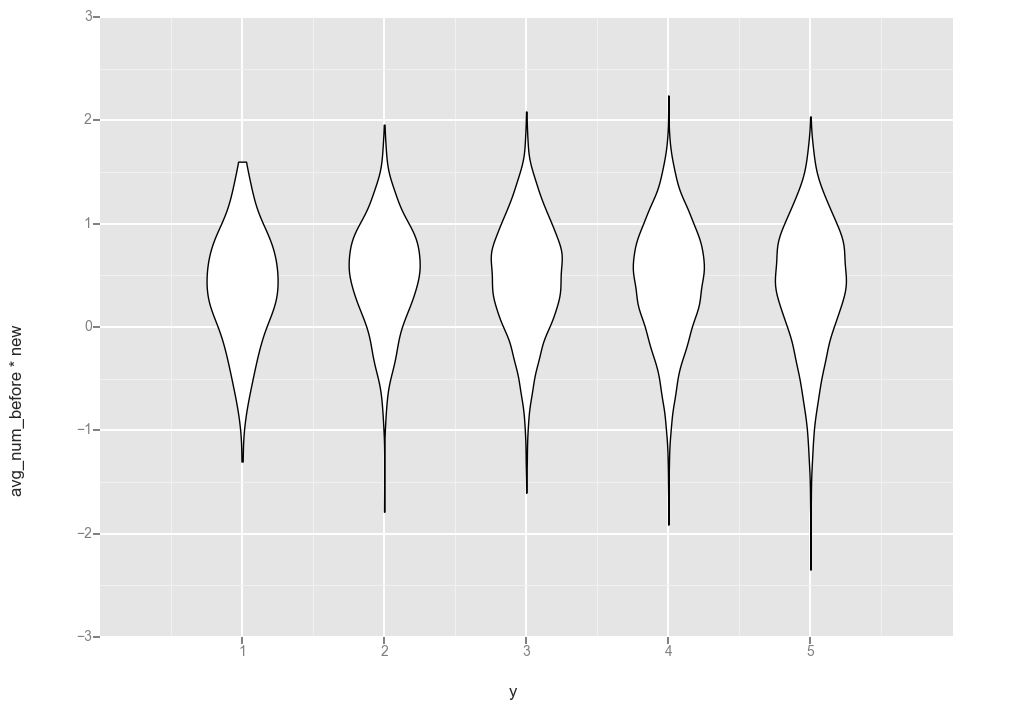

<ggplot: (-9223372036527407563)>

In [457]:
ggplot(tmp, aes('y', 'avg_num_before * new')) + geom_violin()

In [818]:
import numpy as np
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [828]:
tt = X_train.replace(0, np.nan).copy()
tt.head()

title,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,...,Somethings Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook
0,4,4,3,5,4,5,4,4,5,4,...,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,NaN,4.0
1,4,5,3,3,4,3,4,4,3,2,...,4.0,4.0,3.0,2.0,3.0,3.0,NaN,3.0,3.0,5.0
2,5,5,5,5,4,5,4,3,4,5,...,5.0,4.0,4.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN
3,5,5,5,5,4,5,5,3,4,5,...,4.0,5.0,5.0,4.0,4.0,2.0,4.0,2.0,2.0,NaN
4,5,5,5,5,5,5,5,5,5,5,...,3.0,NaN,3.0,NaN,2.0,4.0,5.0,4.0,NaN,5.0


In [825]:
labels, centroids, X_hat = kmeans_missing(tt, n_clusters=5, max_iter=20)

/Users/avivnavon/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:39: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/Users/avivnavon/anaconda/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [826]:
X_train_new_ = pd.DataFrame(X_hat, columns=X_train.columns)
X_train_new_.head()

title,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,...,Somethings Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook
0,4.658138,4.646162,4.480131,4.737071,4.560152,4.813827,4.818182,4.387588,4.372346,4.347305,...,4.227051,4.757562,3.880565,3.298838,4.040312,4.392752,4.154815,3.877762,3.163791,4.606532
1,3.899905,3.841556,3.402751,3.978178,3.834915,4.187856,4.169355,3.386148,3.486717,3.428368,...,3.579024,4.283345,2.890464,2.966443,3.355129,3.519246,3.127906,3.261429,2.799363,4.138159
2,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,3.000000,4.000000,5.000000,...,5.000000,4.000000,4.000000,3.241046,3.745601,5.000000,5.000000,3.542039,3.077058,4.308709
3,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,3.000000,4.000000,5.000000,...,4.000000,5.000000,5.000000,4.000000,4.000000,2.000000,4.000000,2.000000,2.000000,4.308709
4,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,3.000000,4.563841,3.000000,3.241046,2.000000,4.000000,5.000000,4.000000,3.077058,5.000000


In [827]:
X_train.head()

title,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,...,Somethings Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook
0,4,4,3,5,4,5,4,4,5,4,...,5,5,4,4,5,5,5,5,0,4
1,4,5,3,3,4,3,4,4,3,2,...,4,4,3,2,3,3,0,3,3,5
2,5,5,5,5,4,5,4,3,4,5,...,5,4,4,0,0,5,5,0,0,0
3,5,5,5,5,4,5,5,3,4,5,...,4,5,5,4,4,2,4,2,2,0
4,5,5,5,5,5,5,5,5,5,5,...,3,0,3,0,2,4,5,4,0,5


# NN

In [239]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim = 218, activation='relu')) #, init = 'normal' , input_dim=218
    model.add(Dense(15, activation='relu')) #, init = 'normal'
    model.add(Dense(1, activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [240]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

In [241]:
X_train_na_fix_full_scaled.shape

(10000, 218)

In [242]:
start = time.time()
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(estimator, 
                          X_train_na_fix_full_scaled.as_matrix(), 
                          y_train_full.values.ravel(), 
                          cv=kfold,
                          scoring = "neg_mean_squared_error")
end = time.time()
print("Results: %.2f (%.2f) RMSE" % (results.mean() * (-1), results.std()))
print ((end - start) / 60)

Results: 1.12 (0.06) RMSE
24.94067189693451


In [243]:
results

array([-1.03366595, -1.11905353, -1.19988074, -1.15633045, -1.07838762])

## ToDo

- Reapet and avg ?

In [232]:
X_train_na_fix_full_scaled.values

array([[-0.17666399, -0.12039251, -0.72417494, ...,  1.26587114,
        -1.06653958, -0.20753887],
       [-0.17666399,  1.00690334, -0.72417494, ...,  1.08161325,
        -1.06653958,  0.67143224],
       [ 1.06285963,  1.00690334,  1.34642897, ..., -1.12948145,
         1.11117305, -2.53497868],
       ..., 
       [-1.4161876 , -0.12039251, -1.7594769 , ..., -0.11606304,
         0.03029371, -1.07103958],
       [ 1.06285963,  1.00690334, -1.7594769 , ...,  1.48083868,
        -1.06653958, -0.57188247],
       [-0.17666399,  1.00690334,  0.31112701, ...,  0.83593606,
        -1.06653958,  0.68246992]])